# AutoEncoder(tensorflow)

參考資料：
- [Tensorflow Day18 Convolutional Autoencoder - iT 邦幫忙::一起幫忙解決難題，拯救 IT 人的一天](https://ithelp.ithome.com.tw/articles/10188326)

- [利用卷积自编码器对图片进行降噪 - 知乎](https://zhuanlan.zhihu.com/p/27902193)

- [Tensorflow Day 7 : 實作 MNIST 卷積神經網路 Convolutional Neural Network - iT 邦幫忙::一起幫忙解決難題，拯救 IT 人的一天](https://ithelp.ithome.com.tw/articles/10187149)

## 載入 MNIST

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

/home/allenyl/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## 定義helper function

In [2]:
def weight_variable(shape, name='W'):
    w = tf.Variable(tf.truncated_normal(shape=shape, stddev=0.1), name=name)
    # summary op
    tf.summary.histogram('weights', w)
    return w
def bias_variable(shape, name='B'):
    b = tf.Variable(tf.constant(0.1, shape=shape), name=name)
    # summary op
    tf.summary.histogram('biases', b)
    return b

In [3]:
def plot_n_reconstruct(origin_img, reconstruct_img, n =10):
    
    plt.figure(figsize=(40*10/n, 8*10/n))
    
    for i in range(n):
        # display origin
        ax = plt.subplot(2, n, i+1)
        plt.imshow(origin_img[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
        # display reconstruct
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(reconstruct_img[i].reshape(28,28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    plt.show()
    
def plot_n_code(code, n=10):
    from matplotlib import gridspec
    gs = gridspec.GridSpec(1, n, wspace=0.2) 
    
    plt.figure(figsize=(40*10/n,4*10/n))

    for i in range(n):

        x_code = range(len(code[i]))
        y_code = code[i]

        width = 0.5

        #ax = plt.subplot(1, n, i+1)
        ax = plt.subplot(gs[i])
        #ax.set_figheight(28)
        #ax.set_figwidth(28)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.bar(x_code,y_code, width)

    plt.show()
    
    
def plot_n_code_compare(code1, code2):
    import numpy as np

    n = len(code1)
    
    code = np.concatenate((code1,code2), axis=0)

    plt.figure(figsize=(2*10,4))

    for i in range(n):

        x_code = range(len(code[i]))
        y_code = code[i]

        width = 0.5

        ax = plt.subplot(2, 10, i+1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.bar(x_code,y_code, width)

        y_code = code[i+n]
        ax = plt.subplot(2, 10, i+1+n)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.bar(x_code,y_code, width)

    plt.show()
    
    
    
# 隨機補0 噪聲
def add_noise1(imgs):
    # 加入噪声
    noise_factor = 0.5
    # 以機率為 noise_factor 產生 0
    noise = np.random.choice(np.arange(0,2), size=imgs.shape, p=[noise_factor, 1-noise_factor])
    noisy_imgs = imgs * noise
    noisy_imgs = np.clip(noisy_imgs, 0., 1.)
    return noisy_imgs

def test_data_gen1(obj,n=10,keep_prob=1):
    batch = mnist.test.images[0:n, :]
    noise_batch = add_noise1(batch)
    
    print(obj.x_input.shape)
    
    feed_dict = {obj.x_input:noise_batch, obj.keep_prob:keep_prob}
    return noise_batch, feed_dict

# 高斯噪聲
def add_noise2(imgs):
    # 加入噪声
    noise_factor = 0.5
    #print(*imgs.shape)
    # 產生平均為0，標準差為0.5 的噪聲
    noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
    #noisy_imgs = imgs 
    noisy_imgs = np.clip(noisy_imgs, 0., 1.)
    return noisy_imgs

def test_data_gen2(obj,n=10,keep_prob=1):
    batch = mnist.test.images[0:n, :]
    noise_batch = add_noise2(batch)
    
    print(obj.x_input.shape)
    
    feed_dict = {obj.x_input:noise_batch, obj.keep_prob:keep_prob}
    return noise_batch, feed_dict

## Normal Auto Encoder

784->300->30->300->784

- [tf.nn.dropout  |  TensorFlow](https://www.tensorflow.org/api_docs/python/tf/nn/dropout)

- [谈谈Tensorflow的dropout - 简书](https://www.jianshu.com/p/c9f66bc8f96c)

    > 使输入tensor中某些元素变为0，其它没变0的元素变为原来的1/keep_prob大小！

    > 个人总结：个人感觉除非是大型网络，才采用dropout，不然我感觉自己在一些小型网络上，训练好像很是不爽。之前搞一个比较小的网络，搞人脸特征点定位的时候，因为训练数据不够，怕过拟合，于是就采用dropout，最后感觉好像训练速度好慢，从此就对dropout有了偏见，感觉训练过程一直在波动，很是不爽。

- [How do you plot training and validation loss on the same graph using TensorFlow’s TensorBoard? - Quora](https://www.quora.com/How-do-you-plot-training-and-validation-loss-on-the-same-graph-using-TensorFlow%E2%80%99s-TensorBoard)

- [decentralion/tf-dev-summit-tensorboard-tutorial: Code that accompanies my talk at TF Dev Summit 2016](https://github.com/decentralion/tf-dev-summit-tensorboard-tutorial)

- [Hands-on TensorBoard (TensorFlow Dev Summit 2017)](https://youtu.be/eBbEDRsCmv4)

- [[翻译]TensorBoard - 简书](https://www.jianshu.com/p/7d698cebf5f1)

    > 启动TensorBoard
    >
    > 用下面命令启动TensorBoard（或者`python -m tensorflow.tensorboard`）
    >
    > ```
    > tensorboard --logdir=path/to/log-directory
    >
    > ```
    >
    > logir指向FileWriter序列化数据的地方。如果logdir目录包含其他运行的子目录，TensorBoard将把全部数据可视化。TensorBoard运行后，用浏览器到`localhost:6006`查看。

- [tf.summary.image  |  TensorFlow](https://www.tensorflow.org/api_docs/python/tf/summary/image)
- [tf.summary.FileWriter  |  TensorFlow](https://www.tensorflow.org/api_docs/python/tf/summary/FileWriter)
- [How to use tensorboard Embedding Projector? - Stack Overflow](https://stackoverflow.com/questions/40849116/how-to-use-tensorboard-embedding-projector)


In [4]:
import os

class Autoencoder:
    def __init__(self, test_size=-1, embedding_test_batch_size=1024, log_dir='/tmp/tensorflowlogs', train_dir='/train', test_dir='/test'):
        tf.reset_default_graph() # reset graph
        
        self.init_input_place() # init placeholder
        
        self.h_e, self.w, self.h_d = self.build_ae() # build graph

        self.loss_func() # define loss function
        self.train_op() # define train op
        
        init_op = tf.global_variables_initializer() # define initialize operation
        
        self.test_size = test_size # set test data size for evaluation cost
        self.embedding_test_batch_size = embedding_test_batch_size # set test batch size for embedding summary
        
        
        self.sess = tf.InteractiveSession() # open new session
        self.sess.run(init_op) # run initialze operation
        self.init_summary(self.sess, log_dir, train_dir, test_dir) # init tensorboard summary log
        self.embedding_summary()
        
    def init_input_place(self):
        with tf.name_scope('input_data'):
            self.x_input = tf.placeholder(tf.float32, shape=[None, 784], name='x_input')
            self.x_input_reshape = tf.reshape(self.x_input, [-1, 28, 28, 1]) #28 X 28 X 1

            self.x_target = self.x_input
            self.x_target_reshape = self.x_input_reshape
        
        with tf.name_scope('control_variable'):
            self.keep_prob = tf.placeholder(tf.float32, name='dropout_keep_prob')
        
    def loss_func(self):
        with tf.name_scope('cost'):
            self.x_reconstruct = self.h_d[-1]
            loss = tf.pow((self.x_reconstruct - self.x_target),2)
            self.cost = tf.reduce_mean(loss)

    def train_op(self):
        with tf.name_scope('train_step'):
            self.optimizer = tf.train.AdamOptimizer(0.001).minimize(self.cost)
        
    # 執行 tensorboard --logdir=/tmp/tensorflowlogs
    def init_summary(self, sess, log_dir='/tmp/tensorflowlogs', train_dir='/train', test_dir='/test'):
        from datetime import datetime
        now = datetime.now()
        # 儲存tensorboard summary 的地方
        self.summaries_dir = log_dir + '/' + now.strftime("%Y%m%d-%H%M%S")
        # 定義 summary op
        tf.summary.image('input', self.x_input_reshape, 3)
        tf.summary.image('output', tf.reshape(self.x_reconstruct, shape=[-1, 28, 28, 1]), 3)
        self.cost_summary = tf.summary.scalar('cost', self.cost)
        self.merged_summary = tf.summary.merge_all()
        # summary writer
        self.train_writer = tf.summary.FileWriter(self.summaries_dir + train_dir, sess.graph)
        self.test_writer = tf.summary.FileWriter(self.summaries_dir + test_dir)
    
    def embedding_summary(self):
        # test data 的 label 跟小圖，用在 tensorboard 顯示資料點
        LABELS = os.path.join(os.getcwd(), "labels_1024.tsv")
        SPRITES = os.path.join(os.getcwd(), "sprite_1024.png")
        
        ### define embedding input ###
        self.embedding_input = self.h_e[-1]
        #print(self.h_e[-1].shape)
        self.embedding_size = self.h_e[-1].shape[1]
        ##############################
        
        embedding = tf.Variable(tf.zeros([self.embedding_test_batch_size, self.embedding_size]), name="test_embedding")
        self.assignment = embedding.assign(self.embedding_input)
        self.saver = tf.train.Saver()
        
        config = tf.contrib.tensorboard.plugins.projector.ProjectorConfig()
        embedding_config = config.embeddings.add()
        embedding_config.tensor_name = embedding.name
        # test data 的 縮圖路徑
        embedding_config.sprite.image_path = SPRITES
        # test data 的 label 路徑
        embedding_config.metadata_path = LABELS
        # Specify the width and height of a single thumbnail.
        embedding_config.sprite.single_image_dim.extend([28, 28])
        tf.contrib.tensorboard.plugins.projector.visualize_embeddings(self.test_writer, config)
    
    def save_embedding(self, epoch):
        _, test_feed_dict = self.test_data_gen(n=self.embedding_test_batch_size)
        self.sess.run(self.assignment, feed_dict=test_feed_dict)
        self.saver.save(self.sess, os.path.join(self.summaries_dir, "model.ckpt"), epoch)
        
    
    def build_ae(self):

        decoder_list = []
        encoder_list = []
        weight_list = []

        ### encoder ###
        with tf.name_scope('encoder'):
            w = weight_variable([784,300])
            b = bias_variable([300])
            h = tf.nn.sigmoid(tf.add(tf.matmul(self.x_input, w), b))
            out = h
            out = tf.nn.dropout(out, self.keep_prob)
            # add to list
            encoder_list.append(out)
            weight_list.append(w)

            w = weight_variable([300,30])
            b = bias_variable([30])
            h = tf.nn.sigmoid(tf.add(tf.matmul(out, w), b))
            out = h
            
            # get original layer shape
#             out_shape = out.shape.as_list()
#             out_shape[0] = -1 # batch size must be -1
            out_shape = tf.shape(out)
            # flatten layer
            out = tf.layers.Flatten()(out)
            # add to list
            encoder_list.append(out)
            weight_list.append(w)
            
            # restore shape
            out = tf.reshape(out, shape=out_shape)
        
        ### decoder ###
        with tf.name_scope('decoder'):
            w = weight_variable([30, 300])
            b = bias_variable([300])
            h = tf.nn.sigmoid(tf.add(tf.matmul(out, w), b))
            out = h
            out = tf.nn.dropout(out, self.keep_prob)
            # add to list
            decoder_list.append(out)
            weight_list.append(w)

            w = weight_variable([300, 784])
            b = bias_variable([784])
            h = tf.nn.sigmoid(tf.add(tf.matmul(out, w), b))
            out = h
            # add to list
            decoder_list.append(out)
            weight_list.append(w)

        return encoder_list, weight_list, decoder_list


    def train_data_gen(self, n=60, keep_prob=1):
        batch = mnist.train.next_batch(n)[0]
        return batch, {self.x_input:batch, self.keep_prob:keep_prob}
    
    def test_data_gen(self, obj=None, n=10, keep_prob=1):
        batch = mnist.test.images[0:n, :]
        return batch, {self.x_input:batch, self.keep_prob:keep_prob}
    
    def train(self, epoch=20000, keep_prob=1):

        for i in range(epoch):
            _, train_feed_dict = self.train_data_gen(n=60, keep_prob=keep_prob)
            if i < 1500:
                if i % 100 == 0:
                    print("step %d, loss %g" % (i, self.cost.eval(feed_dict=train_feed_dict)))
            else:
                if i % 1000 == 0:
                    print("step %d, loss %g" % (i, self.cost.eval(feed_dict=train_feed_dict)))

            
            ### write tensorboard summary ###
            if i % 200 == 0:
                # test cost
                _, test_feed_dict = self.test_data_gen(n=self.test_size)
                # 執行 summary op
                #summary = self.cost_summary.eval(feed_dict=test_feed_dict)
                # collect all summaries
                summary = self.merged_summary.eval(feed_dict=test_feed_dict)
                self.test_writer.add_summary(summary, i)
                self.test_writer.flush()
                ### save embedding project ###
                self.save_embedding(epoch=i)
                ##############################
                
            # train cost
            # 執行 summary op
            # collect cost summary
            summary = self.cost_summary.eval(feed_dict=train_feed_dict)
            #summary = self.merged_summary.eval(feed_dict=train_feed_dict)
            self.train_writer.add_summary(summary, i)
            self.train_writer.flush()
            
            ### update ###
            self.optimizer.run(feed_dict=train_feed_dict)

        _, test_feed_dict = self.test_data_gen(n=self.test_size)
        print("final loss %g" % self.cost.eval(feed_dict=test_feed_dict))

        for h_i in self.h_e:
            print("average output activation value %g" % tf.reduce_mean(h_i).eval(feed_dict=test_feed_dict))
            
    def plot_test(self, test_size=10, test_data_gen=None, draw_code=True):
        if test_data_gen is None:
            test_data_gen = self.test_data_gen
            
        test_origin_img, test_feed_dict = test_data_gen(obj=self, n=test_size)
        test_reconstruct_img = self.x_reconstruct.eval(feed_dict=test_feed_dict)
        print(self.x_reconstruct.shape)

        plot_n_reconstruct(test_origin_img, test_reconstruct_img, n=test_size)
        
        code = 0
        if draw_code:
            code = tf.layers.Flatten()(self.h_e[-1]).eval(feed_dict=test_feed_dict)
            print(code.shape)

            plot_n_code(code, n=test_size)
        
        return code
    
    def plot_decode(self,code):
        import numpy as np
        n = len(code[0])
        temp = np.zeros(shape=(n,784))
        #test_reconstruct_img = self.sess.run(self.x_reconstruct, feed_dict={self.x_input:temp,tf.layers.Flatten()(self.h_e[-1]):code})
        print("code shape:", code.shape)
        #test_reconstruct_img = self.sess.run(self.x_reconstruct, feed_dict={self.h_e[-1]:code})
        print("layer shape:", self.h_e[-1].shape)
        #code_shape = self.h_e[-1].get_shape().as_list()
        
        test_reconstruct_img = self.sess.run(self.x_reconstruct, feed_dict={self.x_input:temp, self.h_e[-1]:code, self.keep_prob:1})
    
        

        origin_img = test_reconstruct_img
        #code = code_test

        print("image shape:", origin_img.shape)
        plt.figure(figsize=(2*10, 12))

        for i in range(n):
            # display origin
            ax = plt.subplot(6, 10, (int(i/10)*20 + i%10)+1)
            plt.imshow(origin_img[i].reshape(28,28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # plot code
            x_code = range(len(code[i]))
            y_code = code[i]

            width = 0.5

            ax = plt.subplot(6, 10, (((int(i/10))*20+10)  + i % 10) +1 )
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            plt.bar(x_code,y_code, width)

        plt.show()

step 0, loss 0.269443
step 100, loss 0.0641096
step 200, loss 0.0614509
step 300, loss 0.0569889
step 400, loss 0.0488597
step 500, loss 0.04708
step 600, loss 0.0442234
step 700, loss 0.0412435
step 800, loss 0.0387295
step 900, loss 0.0394851
step 1000, loss 0.033706
step 1100, loss 0.0343598
step 1200, loss 0.0325502
step 1300, loss 0.0318563
step 1400, loss 0.0302892
step 2000, loss 0.0277951
step 3000, loss 0.0214534
step 4000, loss 0.0187859
step 5000, loss 0.0170716
step 6000, loss 0.0159678
step 7000, loss 0.0151392
step 8000, loss 0.0137088
step 9000, loss 0.012047
step 10000, loss 0.0122458
step 11000, loss 0.0104421
step 12000, loss 0.0106904
step 13000, loss 0.0106297
step 14000, loss 0.0101888
step 15000, loss 0.00943832
step 16000, loss 0.00929348
step 17000, loss 0.00935016
step 18000, loss 0.00859211
step 19000, loss 0.00846935
final loss 0.00794772
average output activation value 0.416442
average output activation value 0.504707
(?, 784)


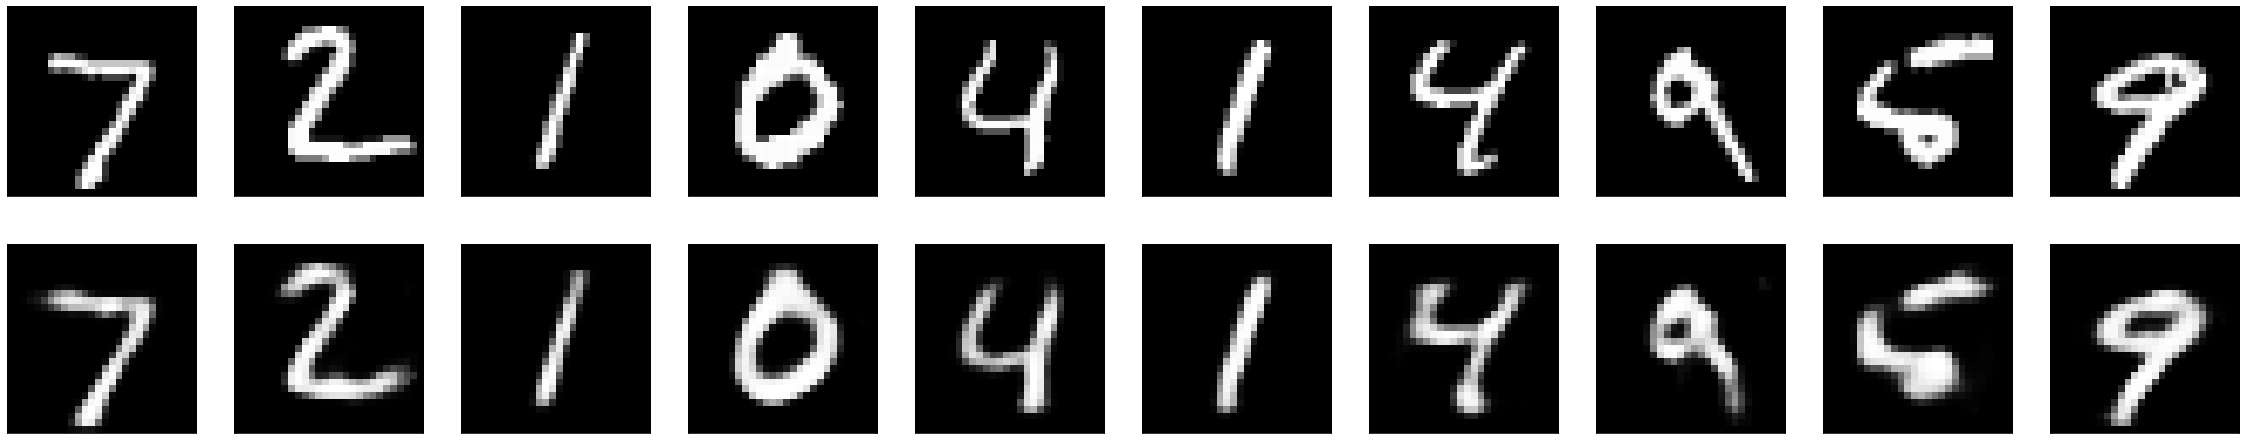

(10, 30)


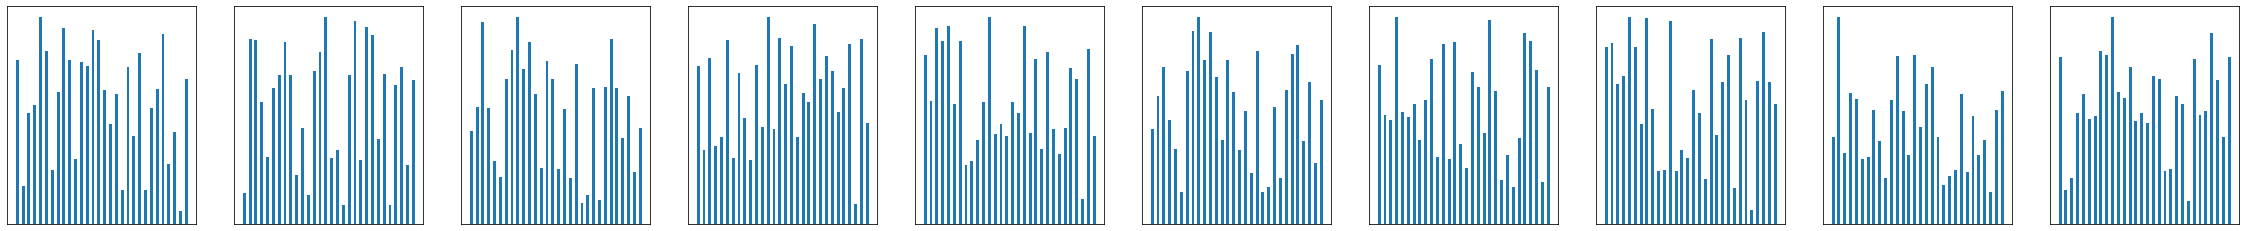

In [5]:
ae = Autoencoder()

ae.train(20000, 1)

code_non_sparse = ae.plot_test(test_size=10)

### 畫出每個維度特徵圖

code shape: (30, 30)
layer shape: (?, 30)
image shape: (30, 784)


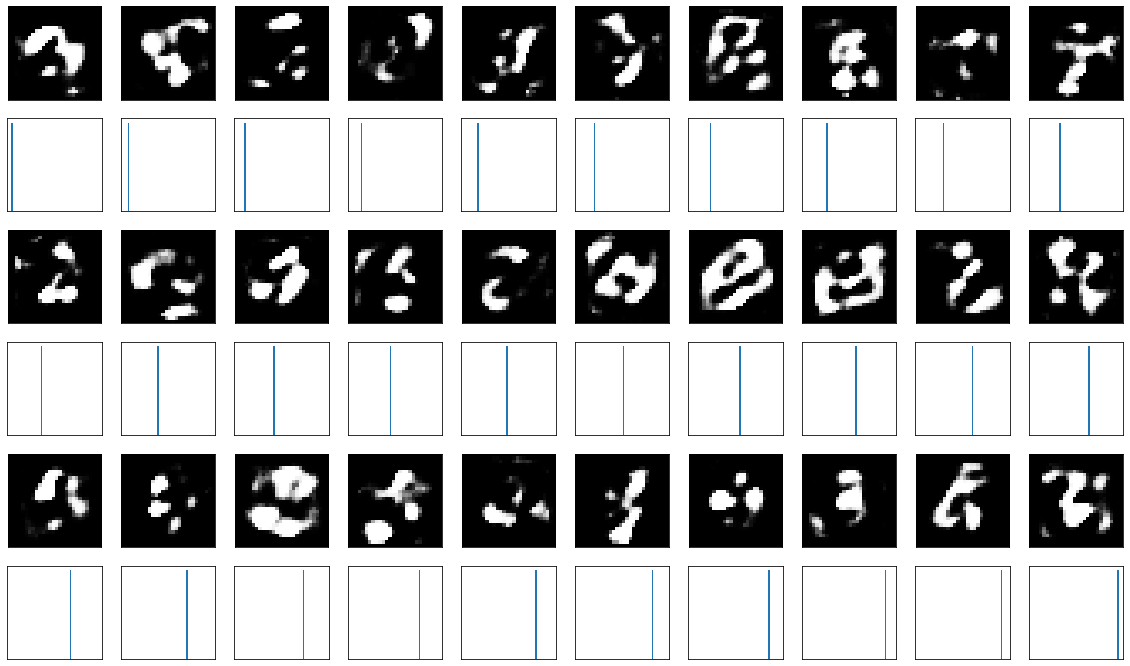

In [6]:
import numpy as np
code_test = np.zeros(shape=(30,30))

for i in range(30):
    code_test[i][i] = 15
    
ae.plot_decode(code_test)

### 測試對抗noise能力

(?, 784)
(?, 784)


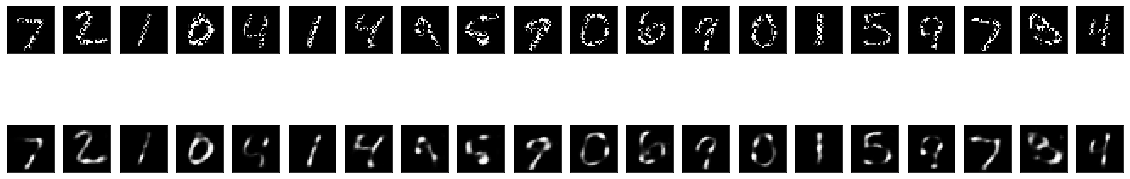

(20, 30)


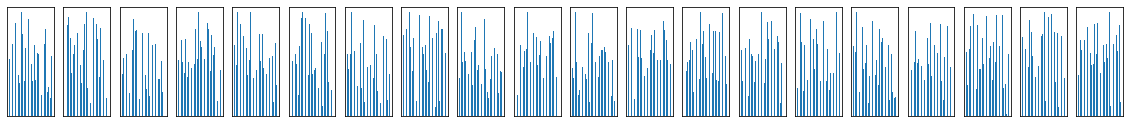

(?, 784)
(?, 784)


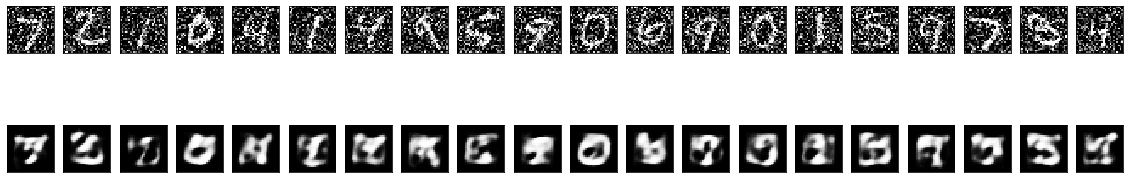

(20, 30)


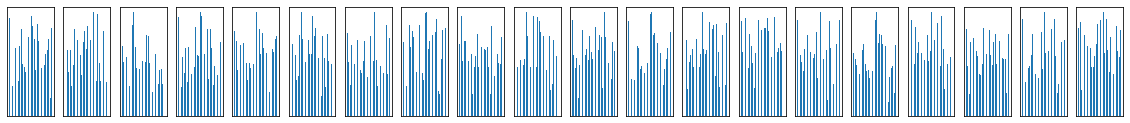

In [7]:
temp = ae.plot_test(test_size=20, test_data_gen=test_data_gen1)
temp = ae.plot_test(test_size=20, test_data_gen=test_data_gen2)

## Sparse Auto encoder

### Loss function

In [8]:
def logfunc(x, x2):
    return tf.multiply(x, tf.log(tf.div(x,x2)))

def kl_div(rho, rho_hat):
    with tf.name_scope('KL_divergence'):
        invrho = tf.subtract(tf.constant(1.),rho)
        invrhohat = tf.subtract(tf.constant(1.),rho_hat)
        logrho = tf.add(logfunc(rho, rho_hat), logfunc(invrho, invrhohat))
    return logrho

In [9]:
class SparseAutoencoder(Autoencoder):
    def loss_func(self):
        with tf.name_scope('cost'):
            from functools import reduce
            alpha = 0
            beta = 7.5e-2
            kl_div_loss = reduce(lambda x, y: x+y, 
                                 map(lambda x: tf.reduce_sum(kl_div(0.02, tf.reduce_mean(x,0))), 
                                     [self.h_e[-1]]))
            l2_loss = reduce(lambda x, y: x+y, map(lambda x:tf.nn.l2_loss(x), self.w))

            self.x_reconstruct = self.h_d[-1]
            reconstruct_loss = tf.reduce_mean(tf.pow(self.x_reconstruct - self.x_target, 2))
            self.cost = reconstruct_loss + alpha * l2_loss + beta * kl_div_loss
        
        with tf.name_scope('train_step'):
            self.optimizer = tf.train.AdamOptimizer(0.01).minimize(self.cost)


/home/allenyl/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


step 0, loss 1.76083
step 100, loss 0.0669892
step 200, loss 0.0683596
step 300, loss 0.0674727
step 400, loss 0.0719787
step 500, loss 0.0700495
step 600, loss 0.0661184
step 700, loss 0.0702213
step 800, loss 0.0719918
step 900, loss 0.067187
step 1000, loss 0.0702984
step 1100, loss 0.0630863
step 1200, loss 0.06305
step 1300, loss 0.0636162
step 1400, loss 0.0706988
step 2000, loss 0.0615699
step 3000, loss 0.0635902
step 4000, loss 0.0555995
step 5000, loss 0.049137
step 6000, loss 0.0434424
step 7000, loss 0.0376999
step 8000, loss 0.0346746
step 9000, loss 0.0352484
step 10000, loss 0.0308461
step 11000, loss 0.0300476
step 12000, loss 0.0267294
step 13000, loss 0.027666
step 14000, loss 0.0254241
step 15000, loss 0.0257061
step 16000, loss 0.0208761
step 17000, loss 0.0210654
step 18000, loss 0.0209863
step 19000, loss 0.0202161
step 20000, loss 0.0187307
step 21000, loss 0.022705
step 22000, loss 0.0202378
step 23000, loss 0.0200263
step 24000, loss 0.0174386
step 25000, loss 

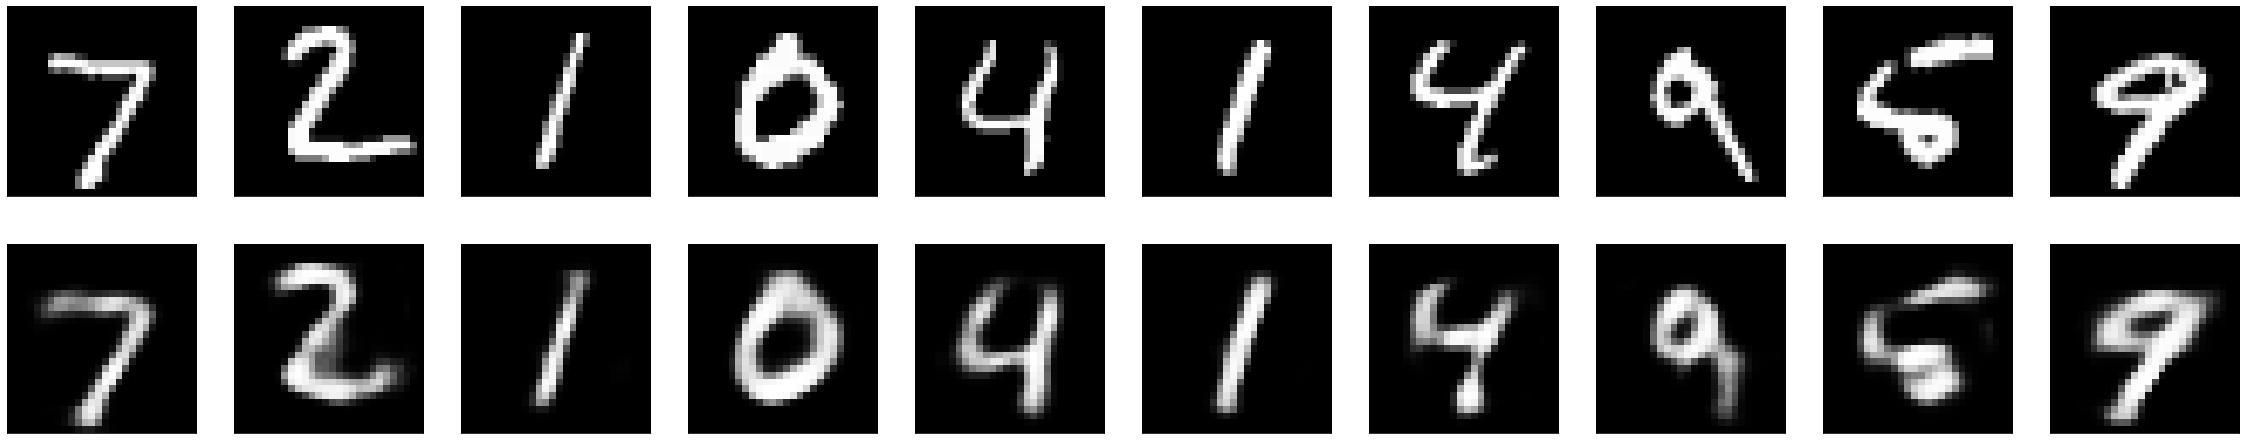

(10, 30)


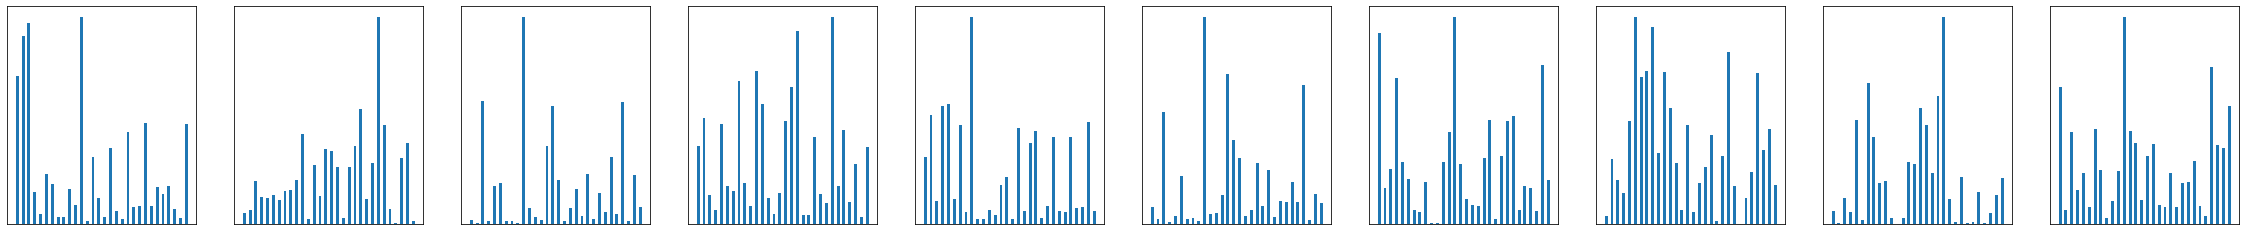

In [10]:
sae = SparseAutoencoder(train_dir='/train_sparse', test_dir='/test_sparse')

sae.train(30000)

code_sparse = sae.plot_test(test_size=10)


### 畫出每個維度特徵圖

code shape: (30, 30)
layer shape: (?, 30)
image shape: (30, 784)


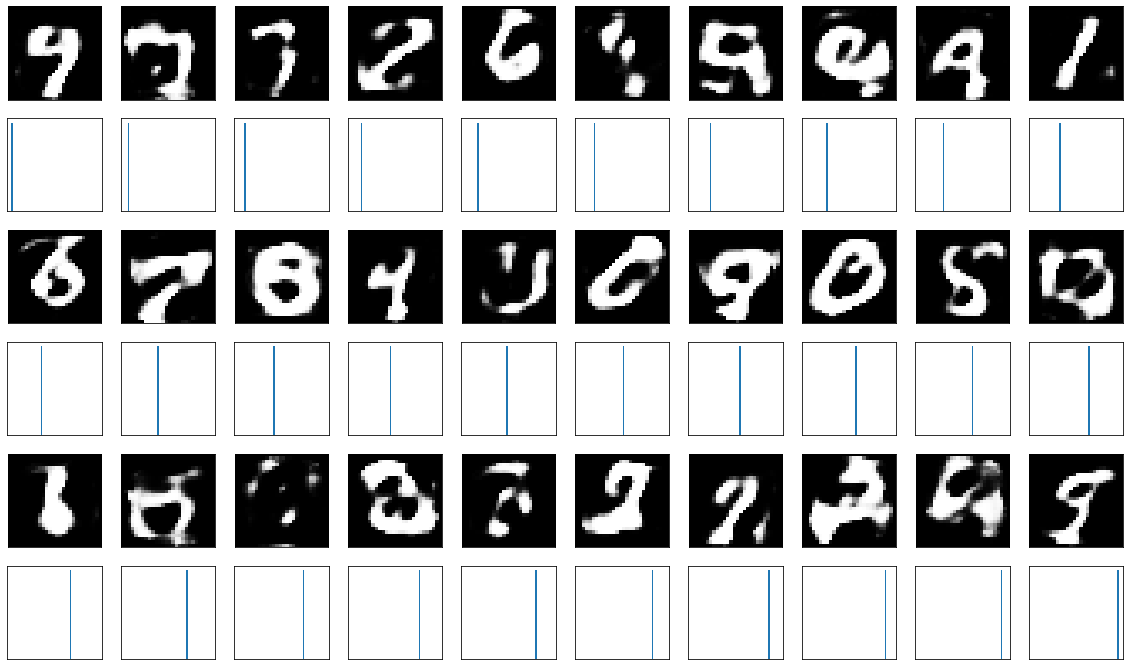

In [11]:
code_test = np.zeros(shape=(30,30))

for i in range(30):
    code_test[i][i] = 0.6
    
sae.plot_decode(code_test)

### 測試對抗noise能力

(?, 784)
(?, 784)


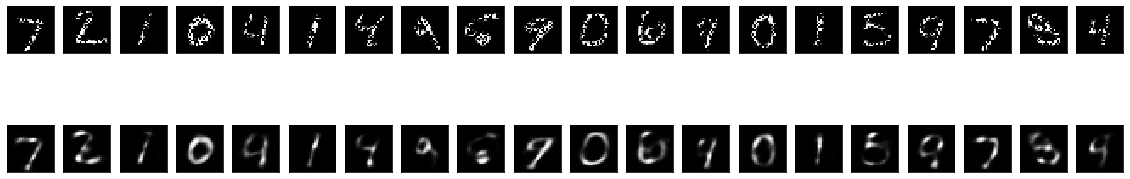

(20, 30)


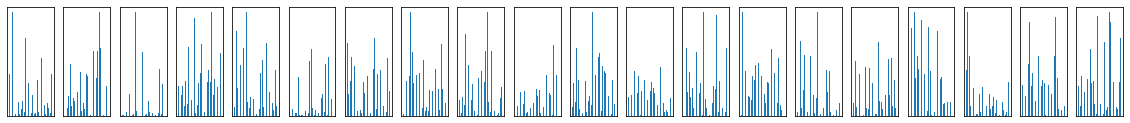

(?, 784)
(?, 784)


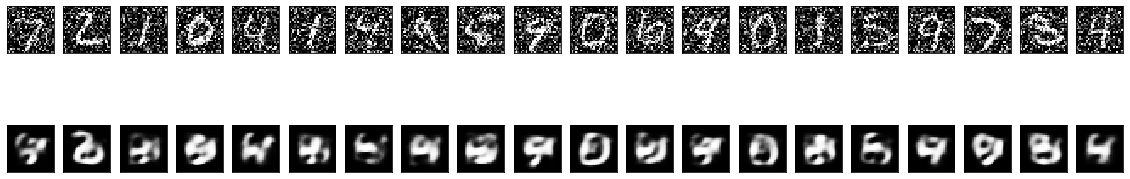

(20, 30)


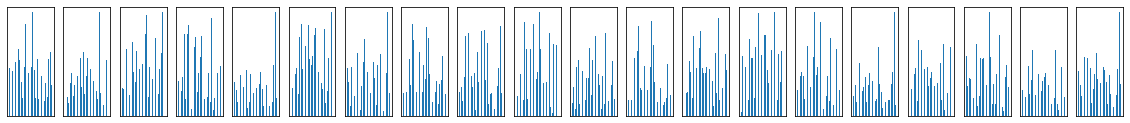

In [12]:
temp = sae.plot_test(test_size=20, test_data_gen=test_data_gen1)
temp = sae.plot_test(test_size=20, test_data_gen=test_data_gen2)

## 比較 non-sparse 與 sparse

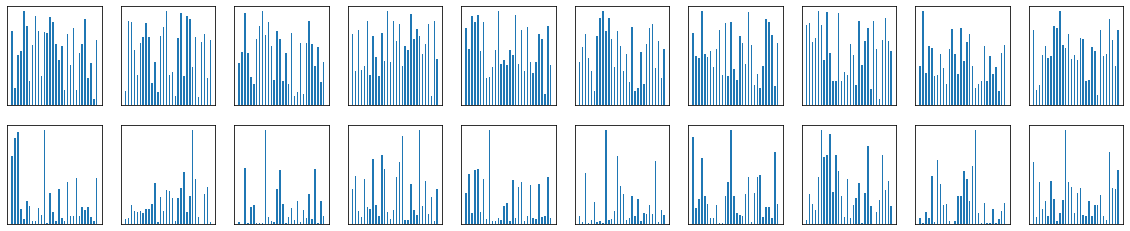

In [13]:
plot_n_code_compare(code_non_sparse, code_sparse)

## Convolution Auto Encoder (with stride 2X2, 卷積核每次移動2格)

In [14]:
def conv2d(x, w, name='conv2d'):
    return tf.nn.conv2d(x, w, strides=[1,2,2,1], padding='SAME', name=name)

def deconv2d(x, w, output_shape, name='deconv2d'):
    return tf.nn.conv2d_transpose(x, w, output_shape, strides = [1, 2, 2, 1], padding = 'SAME', name=name)

In [15]:
class ConvolutionAutoEncoder(Autoencoder):
    def init_input_place(self):
        with tf.name_scope('input_data'):
            self.x_input = tf.placeholder(tf.float32, shape=[None, 784])
            self.x_input_reshape = tf.reshape(self.x_input, [-1, 28, 28, 1]) #28 X 28 X 1

            self.x_target = self.x_input_reshape
            self.x_target_reshape = self.x_input_reshape
        
        with tf.name_scope('control_variable'):
            self.keep_prob = tf.placeholder(tf.float32)
        
    def build_ae(self):
        decoder_list = []
        encoder_list = []
        weight_list = []
        
        
        ### encoder ###
        with tf.name_scope('encoder'):
            w = weight_variable([5,5,1,64])
            b = bias_variable([64])
            h = tf.nn.relu(tf.add(conv2d(self.x_input_reshape, w), b)) # 14 X 14 X 64
            out = h
            # add to list
            encoder_list.append(out)
            weight_list.append(w)


            w = weight_variable([5,5,64,1])
            b = bias_variable([1])
            h = tf.nn.relu(tf.add(conv2d(out, w), b)) # 7 X 7 X 1
            out = h

            # get original layer shape
            out_shape = tf.shape(out)
            # flatten layer
            out = tf.layers.Flatten()(out)
            # add to list
            encoder_list.append(out)
            weight_list.append(w)
            
            # restore shape
            out = tf.reshape(out, shape=out_shape)
        
        
        ### decoder ###
        with tf.name_scope('decoder'):
            w = weight_variable([5,5,64,1])
            b = bias_variable([64])
            output_shape = tf.stack([tf.shape(self.x_input_reshape)[0], 14, 14, 64])
            h = tf.nn.relu(tf.add(deconv2d(out, w, output_shape), b)) # 14 X 14 X 64
            out = h
            # add to list
            decoder_list.append(out)
            weight_list.append(w)


            w = weight_variable([5,5,1,64])
            b = bias_variable([1])
            output_shape = tf.stack([tf.shape(self.x_input_reshape)[0], 28, 28, 1])
            # 最後一層要用 sigmoid (因為input 是0~1 的值)
            h = tf.nn.sigmoid(tf.add(deconv2d(out, w, output_shape), b)) # 28 X 28 X 1
            out = h
            # add to list
            decoder_list.append(out)
            weight_list.append(w)

        return encoder_list, weight_list, decoder_list
    
    def plot_conv_layer(self, layer, image, num_filters):
        import math
        output = self.sess.run(layer, feed_dict = {self.x_input: [image], self.keep_prob:1})

        num_grids = int(math.ceil(math.sqrt(num_filters)))

        fig, axes = plt.subplots(num_grids, num_grids)

        for i, ax in enumerate(axes.flat):
            if i < num_grids * num_grids:
                img = output[0, :, :, i]
                ax.imshow(img, interpolation='nearest', cmap='gray')

            ax.set_xticks([])
            ax.set_yticks([])

        plt.show()

/home/allenyl/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


step 0, loss 0.270031
step 100, loss 0.0484589
step 200, loss 0.0263429
step 300, loss 0.0220723
step 400, loss 0.0189318
step 500, loss 0.0177185
step 600, loss 0.0159518
step 700, loss 0.0176807
step 800, loss 0.0148785
step 900, loss 0.0152175
step 1000, loss 0.0145866
step 1100, loss 0.0142248
step 1200, loss 0.0136805
step 1300, loss 0.0137763
step 1400, loss 0.0129254
step 2000, loss 0.0121269
step 3000, loss 0.00920603
step 4000, loss 0.0104237
step 5000, loss 0.00947954
step 6000, loss 0.00974351
step 7000, loss 0.0092412
step 8000, loss 0.00873884
step 9000, loss 0.00903725
step 10000, loss 0.00919261
step 11000, loss 0.00835311
step 12000, loss 0.00840705
step 13000, loss 0.00898748
step 14000, loss 0.00765794
step 15000, loss 0.00806897
step 16000, loss 0.00812732
step 17000, loss 0.00874687
step 18000, loss 0.00805312
step 19000, loss 0.00756095
final loss 0.00782617
average output activation value 0.223765
average output activation value 9.19031
(?, 28, 28, 1)


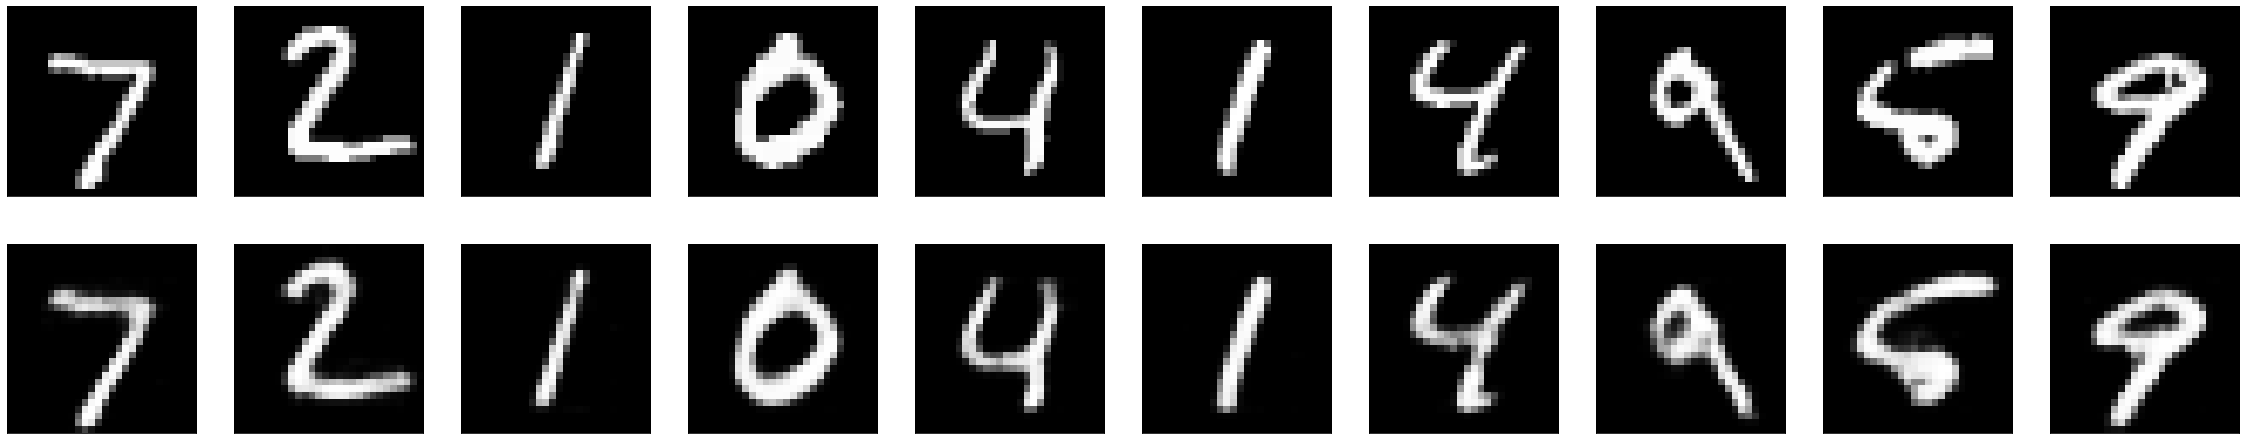

(10, 49)


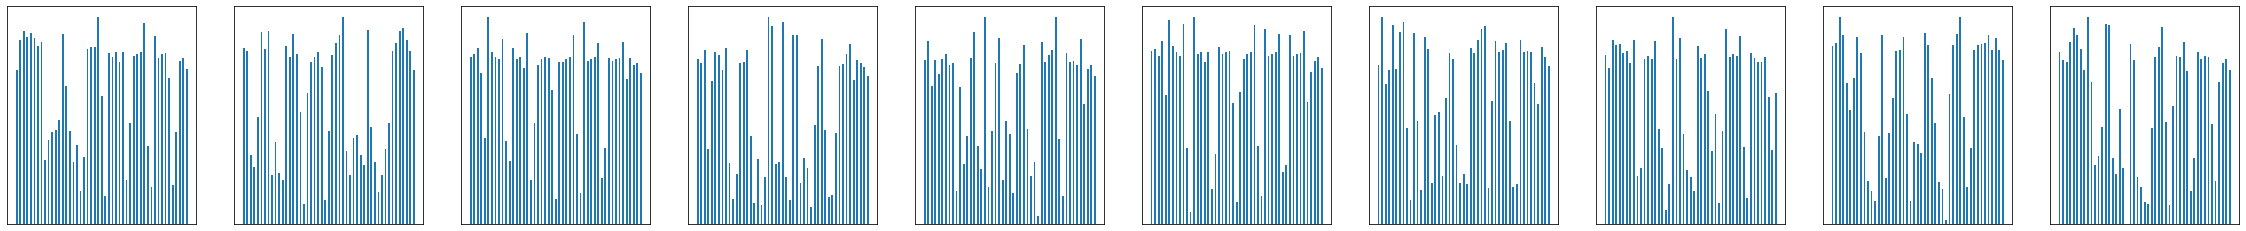

In [16]:
conv_ae = ConvolutionAutoEncoder(train_dir='/train_conv', test_dir='/test_conv')

conv_ae.train(20000)

code = conv_ae.plot_test(10, draw_code=True)

### 畫出第一層filter

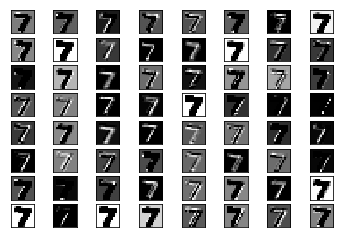

In [17]:
image1 = mnist.test.images[0]
conv_ae.plot_conv_layer(conv_ae.h_e[0], image1, 64)

### 測試對抗noise能力

(?, 784)
(?, 28, 28, 1)


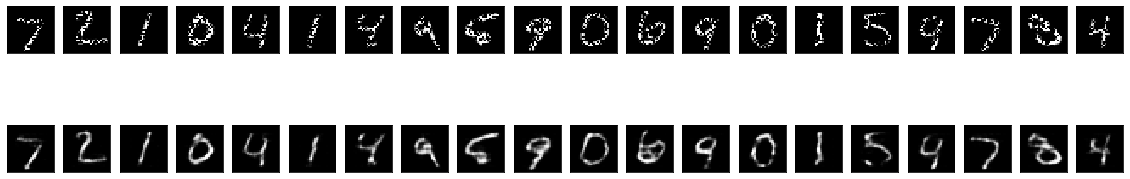

(20, 49)


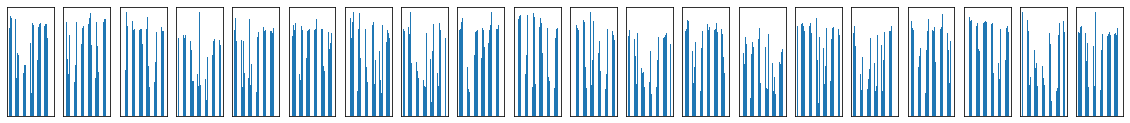

(?, 784)
(?, 28, 28, 1)


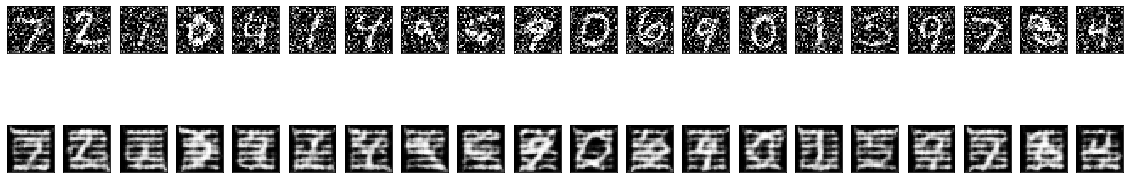

(20, 49)


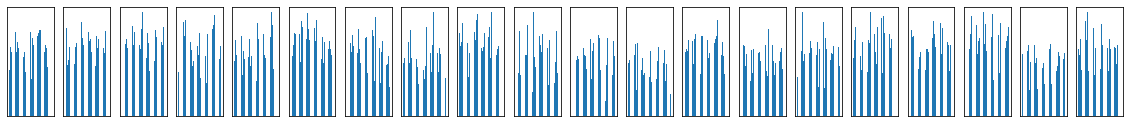

In [18]:
temp = conv_ae.plot_test(test_size=20, test_data_gen=test_data_gen1)
temp = conv_ae.plot_test(test_size=20, test_data_gen=test_data_gen2)

## Convolution Auto Encoder with max pooling

- [Tensorflow Day18 Convolutional Autoencoder - iT 邦幫忙::一起幫忙解決難題，拯救 IT 人的一天](https://ithelp.ithome.com.tw/articles/10188326)

    使用 `tf.nn.max_pool_with_argmax` 這個函數，它除了會回傳 pooling 的結果外也會回傳對應原本的索引值 (argmax)，如下．

    > The indices in argmax are flattened, so that a maximum value at position [b, y, x, c] becomes flattened index ((b * height + y) * width + x) * channels + c.

    理論上在做 unpooling 的時就會用到這裡產生的對應表．不過目前 tensorflow 中沒有 unpooling 這個 op (可以參考 [issue](https://github.com/tensorflow/tensorflow/issues/2169))．因此以下展示了兩種方法作 unpooling 也都不會用到 argmax．

    1.  使用 Github Issue 討論中的方法，也就是放大兩倍後在固定的地方填值 (ex. 左上角)

    2.  借用影像的 upsample 函數 `tf.image.resize_nearest_neighbor` 來做等比例放大，也就不會補 0．
    
- [tf.nn.max_pool_with_argmax  |  TensorFlow](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool_with_argmax)
- [tf.zeros_like  |  TensorFlow](https://www.tensorflow.org/api_docs/python/tf/zeros_like)
- [tf.concat  |  TensorFlow](https://www.tensorflow.org/api_docs/python/tf/concat)
- [tf.image.resize_images  |  TensorFlow](https://www.tensorflow.org/api_docs/python/tf/image/resize_images)


In [19]:
#convolution, deconvolution, pooling, unpooling

def conv2d(x, w, name='convs2'):
    return tf.nn.conv2d(x, w, strides=[1,1,1,1], padding='SAME', name=name)

def deconv2d(x, w, output_shape, name='deconv2d'):
    return tf.nn.conv2d_transpose(x, w, output_shape, strides = [1, 1, 1, 1], padding = 'SAME', name=name)

def max_pool_2x2(x):
    with tf.name_scope('max_pool_2x2'):
        print("max_pool_2x2")
        print(x.shape)
        out = tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
        print(out.shape)
    return out

def max_unpool_2x2(x, shape):
    with tf.name_scope('max_unpool_2x2'):
        print("max_unpool_2x2")
        print(x.shape)
        # NEAREST_NEIGHBOR 速度最快，效果跟 BILINEAR, BICUBIC 差不多，但 BICUBIC 非常慢
        inference = tf.image.resize_images(x, [shape[1], shape[2]], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        print(inference.shape)
    return inference

def max_unpool_2x2_fill_zero(x, output_shape):
    with tf.name_scope('max_unpool_2x2_fill_zero'):
        print("max_unpool_2x2_fill_zero")
        print(x.shape)
        out = tf.concat([x, tf.zeros_like(x)], 3)
        out = tf.concat([out, tf.zeros_like(out)], 2)
        out_size = output_shape
        out = tf.reshape(out, out_size)
        print(out.shape)
    return out

In [20]:
class ConvolutionMaxpoolFillZeroAutoEncoder(ConvolutionAutoEncoder):
    def build_ae(self):
        decoder_list = []
        encoder_list = []
        weight_list = []
        
        ### encoder ###
        with tf.name_scope('encoder'):
            w = weight_variable([5,5,1,64])
            b = bias_variable([64])
            h = tf.nn.relu(tf.add(conv2d(self.x_input_reshape, w), b)) # 28 X 28 X 64
            out = max_pool_2x2(h) # 14 X 14 X 64
            # add to list
            encoder_list.append(out)
            weight_list.append(w)


            w = weight_variable([5,5,64,1])
            b = bias_variable([1])
            h = tf.nn.relu(tf.add(conv2d(out, w), b)) # 14 X 14 X 1
            out = max_pool_2x2(h) # 7 X 7 X 1

            # get original layer shape
            out_shape = tf.shape(out)
            # flatten layer
            out = tf.layers.Flatten()(out)
            # add to list
            encoder_list.append(out)
            weight_list.append(w)            
            
            # restore shape
            out = tf.reshape(out, shape=out_shape)
        
        ### decoder ###
        with tf.name_scope('decoder'):
            w = weight_variable([5,5,64,1])
            b = bias_variable([64])
            output_shape = tf.stack([tf.shape(self.x_input_reshape)[0], 7, 7, 64])
            h = tf.nn.relu(tf.add(deconv2d(out, w, output_shape), b)) # 7 X 7 X 64
            output_shape = tf.stack([tf.shape(self.x_input_reshape)[0], 14, 14, 64])
            out = max_unpool_2x2_fill_zero(h, output_shape) # 14 X 14 X 64
            # add to list
            decoder_list.append(out)
            weight_list.append(w)


            w = weight_variable([5,5,1,64])
            b = bias_variable([1])
            output_shape = tf.stack([tf.shape(self.x_input_reshape)[0], 14, 14, 1])
            h = tf.nn.relu(tf.add(deconv2d(out, w, output_shape), b)) # 14 X 14 X 1
            output_shape = tf.stack([tf.shape(self.x_input_reshape)[0], 28, 28, 1])
            out = max_unpool_2x2_fill_zero(h, output_shape) # 28 X 28 X 1
            # add to list
            decoder_list.append(out)
            weight_list.append(w)

        return encoder_list, weight_list, decoder_list

max_pool_2x2
(?, 28, 28, 64)
(?, 14, 14, 64)
max_pool_2x2
(?, 14, 14, 1)
(?, 7, 7, 1)
max_unpool_2x2_fill_zero
(?, 7, 7, 64)
(?, 14, 14, 64)
max_unpool_2x2_fill_zero
(?, 14, 14, 1)
(?, 28, 28, 1)


/home/allenyl/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


step 0, loss 0.111893
step 100, loss 0.0925866
step 200, loss 0.0843653
step 300, loss 0.0904431
step 400, loss 0.0824483
step 500, loss 0.0879732
step 600, loss 0.0889006
step 700, loss 0.0849468
step 800, loss 0.0799971
step 900, loss 0.0978966
step 1000, loss 0.0854001
step 1100, loss 0.0905951
step 1200, loss 0.0940929
step 1300, loss 0.0909671
step 1400, loss 0.0848468
step 2000, loss 0.086527
step 3000, loss 0.0882186
step 4000, loss 0.0758539
step 5000, loss 0.0857554
step 6000, loss 0.082875
step 7000, loss 0.0897909
step 8000, loss 0.0887156
step 9000, loss 0.0790072
step 10000, loss 0.0887685
step 11000, loss 0.0843303
step 12000, loss 0.0857324
step 13000, loss 0.0918198
step 14000, loss 0.0863222
step 15000, loss 0.0838051
step 16000, loss 0.079364
step 17000, loss 0.0891581
step 18000, loss 0.085312
step 19000, loss 0.0855654
final loss 0.0870156
average output activation value 0.132557
average output activation value 1.35414
(?, 28, 28, 1)


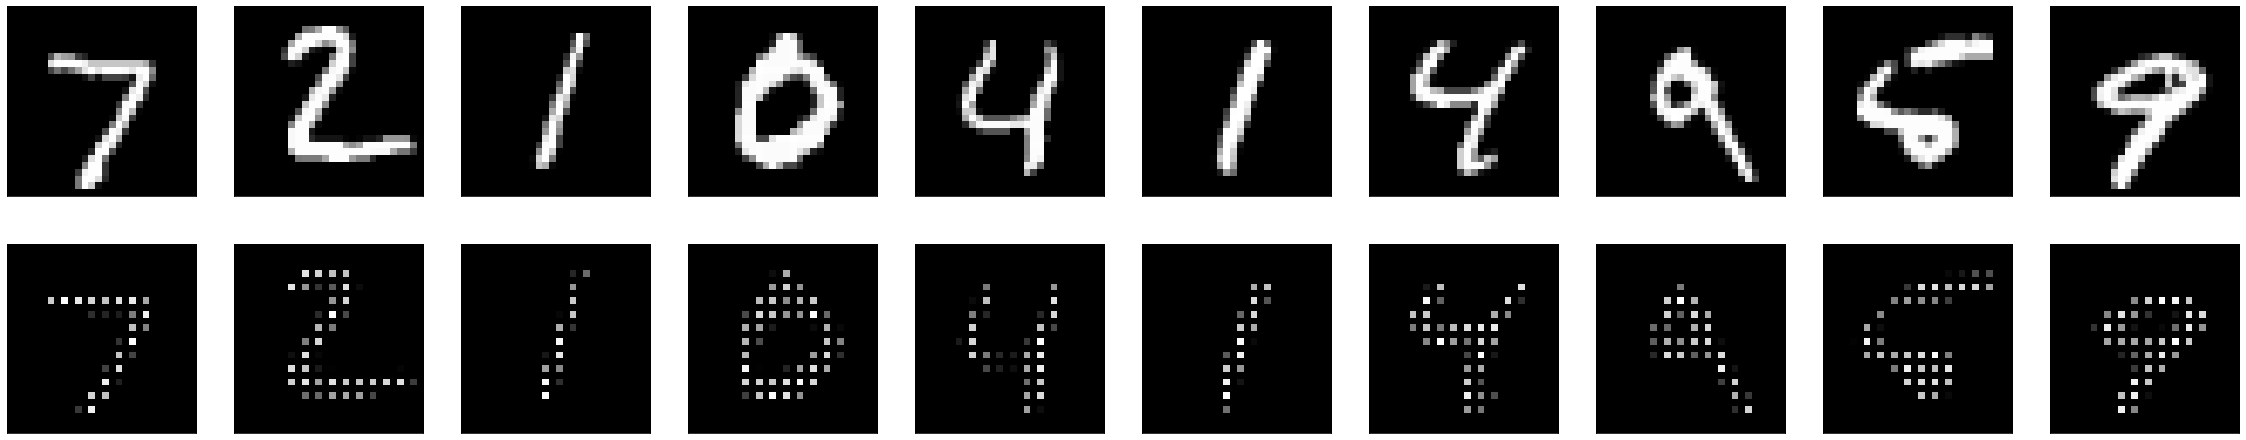

(10, 49)


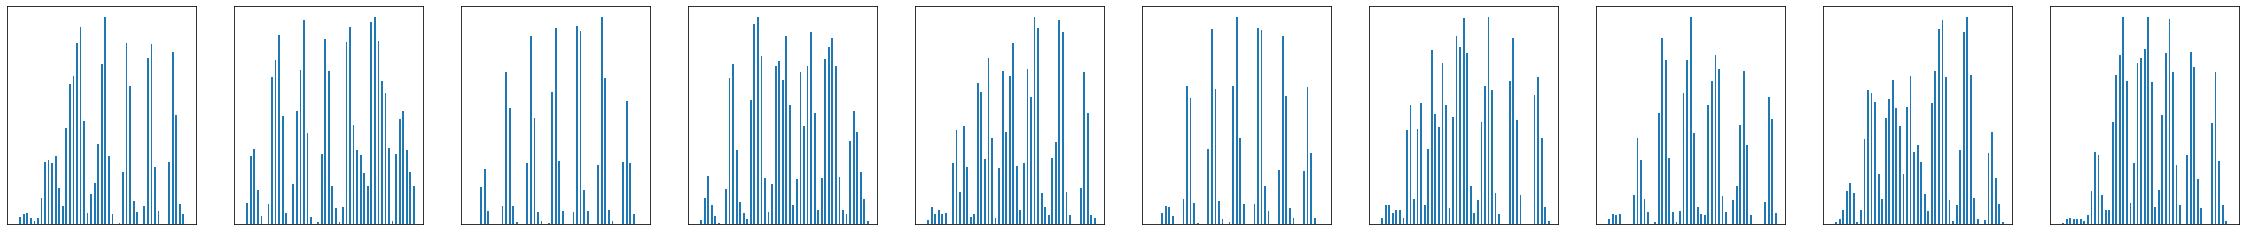

In [21]:
convmax_ae = ConvolutionMaxpoolFillZeroAutoEncoder(train_dir='/train_conv_maxpool', test_dir='/test_conv_maxpool')

convmax_ae.train(20000)

code = convmax_ae.plot_test(10, draw_code=True)

### 畫出第一層filter

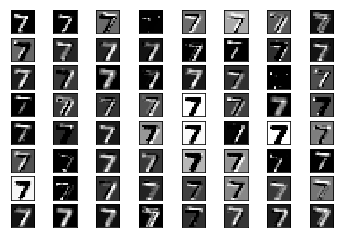

In [22]:
image1 = mnist.test.images[0]
convmax_ae.plot_conv_layer(convmax_ae.h_e[0], image1, 64)

### 測試對抗noise能力

(?, 784)
(?, 28, 28, 1)


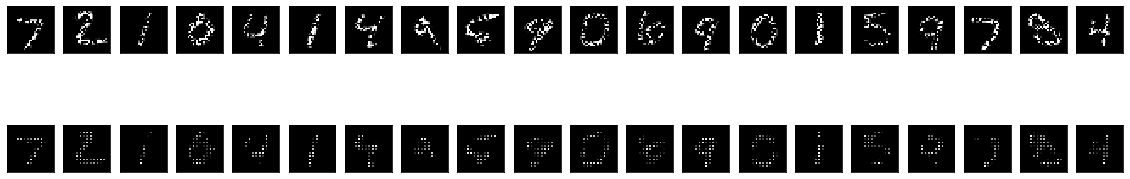

(20, 49)


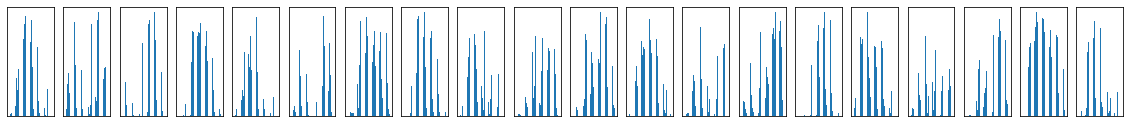

(?, 784)
(?, 28, 28, 1)


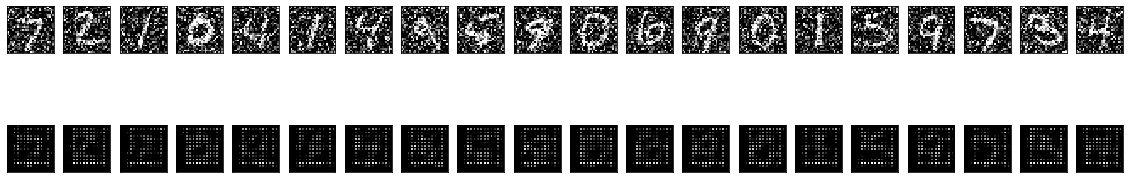

(20, 49)


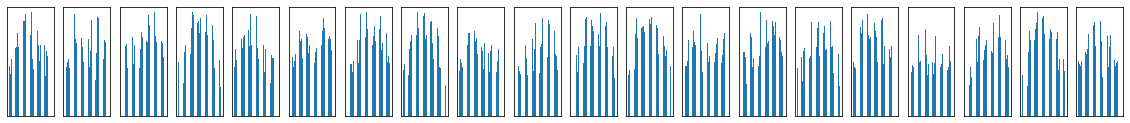

In [23]:
temp = convmax_ae.plot_test(test_size=20, test_data_gen=test_data_gen1)
temp = convmax_ae.plot_test(test_size=20, test_data_gen=test_data_gen2)

## max_unpool_2x2 補零法

In [24]:
# 在越後方的維度表示越內層括號
test = tf.constant([[[1,2,3],[4,5,6]],[[7,8,9],[10,11,12]]]) # 2 X 2 X 3
print(test.eval()[:,:,0]) # 印出 2 X 2

# 從內層括號新增 0 之後 reshape 到外層，就會產生插入0的效果
test_out = tf.concat([test, tf.zeros_like(test)], 2) # 2 X 2 X 6
test_out = test_out.eval().reshape([2,4,3]) # 2 X 4 X 3
print(test_out[:,:,0]) # 印出 2 X 4

# 再做一次新增 0 reshape，就會產生原始數字在左上角，其他為0的效果
test_out = tf.concat([test_out, tf.zeros_like(test_out)], 1) # 2 X 8 X 3
test_out = test_out.eval().reshape([4,4,3]) # 4 X 4 X 3
print(test_out[:,:,0]) # 印出 4 X 4

[[ 1  4]
 [ 7 10]]
[[ 1  0  4  0]
 [ 7  0 10  0]]
[[ 1  0  4  0]
 [ 0  0  0  0]
 [ 7  0 10  0]
 [ 0  0  0  0]]


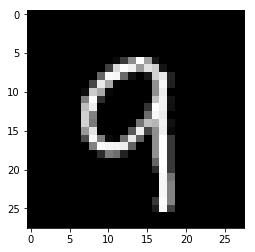

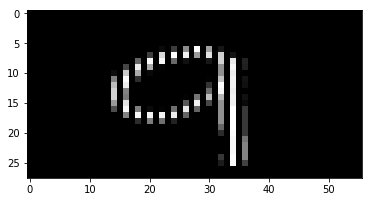

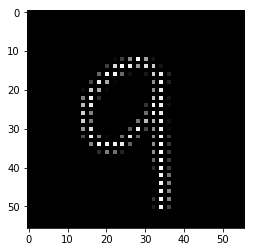

In [25]:
# 在越後方的維度表示越內層括號
batch = mnist.train.next_batch(60)
x = batch[0]
x_origin = tf.reshape(x, [-1, 28, 28, 1])

plt.imshow(x_origin.eval()[0,:,:,0])
plt.gray()
plt.show()

# 從內層括號新增 0 之後 reshape 到外層，就會產生插入0的效果
out = tf.concat([x_origin, tf.zeros_like(x_origin)], 3) # -1 X 28 X 28 X 2
out = tf.reshape(out, [-1, 28, 56, 1]) # -1 X 28 X 56 X 1

plt.imshow(out.eval()[0,:,:,0])
plt.gray()
plt.show()

# 再做一次新增 0 reshape，就會產生原始數字在左上角，其他為0的效果
out = tf.concat([out, tf.zeros_like(out)], 2) # -1 X 28 X 112 X 1
out = tf.reshape(out, [-1, 56, 56, 1]) # -1 X 56 X 56 X 1

plt.imshow(out.eval()[0,:,:,0])
plt.gray()
plt.show()

## Sparse Convolution AutoEncoder with max pooling

- [TF里几种loss和注意事项 - 知乎](https://zhuanlan.zhihu.com/p/33560183)

    > **准备1、**先说一下什么是logit，logit函数定义为：
    > 
    > ![L(p)=ln\frac{p}{1-p}](https://www.zhihu.com/equation?tex=L%28p%29%3Dln%5Cfrac%7Bp%7D%7B1-p%7D)
    > 
    > 是一种将取值范围在\[0,1\]内的概率映射到实数域\[-inf,inf\]的函数，如果p=0.5，函数值为0；p<0.5，函数值为负；p>0.5，函数值为正。
    > 
    > **相对地**，softmax和sigmoid则都是将\[-inf,inf\]映射到\[0,1\]的函数。
    > 
    > 在tensorflow里的"logits"指的其实是，该方法是在**logit数值**上使用softmax或者sigmoid来进行normalization的，也暗示用户**不要**将网络输出进行sigmoid或者softmax，这些过程可以在函数内部更高效地计算。
    > 
    > **准备2、**独立和互斥
    > 
    > 有事件A和B
    > 
    > 独立：P(AnB) = P(A) * P(B)
    > 
    > 互斥：P(AUB) = P(A) + P(B), P(AnB) = 0
    > 
    > **准备3、**cross entropy loss + softmax + sigmoid
    > 
    > 请看之前的文章，[复习：常见的损失函数](https://zhuanlan.zhihu.com/p/33542937)
    
    - [tf.nn.sigmoid_cross_entropy_with_logits  |  TensorFlow](https://www.tensorflow.org/versions/r1.4/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits)
    
    计算网络输出logits和标签labels的sigmoid cross entropy loss，衡量独立不互斥离散分类任务的误差，说独立不互斥离散分类任务是因为，在这些任务中类与类之间是独立但是不互斥的，拿多分类任务中的多目标检测来举例子，一张图中可以有各种instance，比如有一只狗和一只猫。对于一个总共有五类的多目标检测任务，假如网络的输出层有5个节点，label的形式是[1,1,0,0,1]这种，1表示该图片有某种instance，0表示没有。那么，每个instance在这张图中有没有这显然是独立事件，但是多个instance可以存在一张图中，这就说明事件们并不是互斥的。所以我们可以直接将网络的输出用作该方法的logits输入，从而进行输出与label的cross entropy loss。

    更加直白的来说，这种网络的输入不需要进行one hot处理，网络输出即是函数logits参数的输入。

    剖开函数内部，因为labels和logits的形状都是[batch_size, num_classes]，那么如何计算他们的交叉熵呢，毕竟它们都不是有效的概率分布（一个batch内输出结果经过sigmoid后和不为1）。其实loss的计算是element-wise的，方法返回的loss的形状和labels是相同的，也是[batch_size, num_classes]，再调用reduce_mean方法计算batch内的平均loss。所以这里的cross entropy其实是一种class-wise的cross entropy，每一个class是否存在都是一个事件，对每一个事件都求cross entropy loss，再对所有的求平均，作为最终的loss。
    
    - [tf.nn.softmax_cross_entropy_with_logits  |  TensorFlow](https://www.tensorflow.org/versions/r1.4/api_docs/python/tf/nn/softmax_cross_entropy_with_logits)
    
    计算网络输出logits和标签labels的softmax cross entropy loss，衡量独立互斥离散分类任务的误差，说独立互斥离散分类任务是因为，在这些任务中类与类之间是独立而且互斥的，比如VOC classification、Imagenet、CIFAR-10甚至MNIST，这些都是多分类任务，但是一张图就对应着一个类，class在图片中是否存在是独立的，并且一张图中只能有一个class，所以是独立且互斥事件。

    该函数要求每一个label都是一个有效的概率分布，对于Imagenet中的ILSVRC2012这种任务，那么label应该就对应一个one hot编码，ILSVRC2012提供的数据集中一共有1000个类，那么label就应该是一个1x1000的vector，形式为[0,0,...,1,0,....0]，1000个元素中有且只有一个元素是1，其余都是0。

    这样要求的原因很简单，因为网络的输出要进行softmax，得到的就是一个有效的概率分布，这里不同与sigmoid，因为sigmoid并没有保证网络所有的输出经过sigmoid后和为1，不是一个有效的概率分布。

    有了labels和softmax后的logits，就可以计算交叉熵损失了，最后得到的是形状为[batch_size, 1]的loss。
       
    - [tf.nn.sparse_softmax_cross_entropy_with_logits  |  TensorFlow](https://www.tensorflow.org/versions/r1.4/api_docs/python/tf/nn/sparse_softmax_cross_entropy_with_logits)
    
    这个版本是tf.nn.softmax_cross_entropy_with_logits的易用版本，这个版本的logits的形状依然是[batch_size, num_classes]，但是labels的形状是[batch_size, 1]，每个label的取值是从[0, num_classes)的离散值，这也更加符合我们的使用习惯，是哪一类就标哪个类对应的label。

    如果已经对label进行了one hot编码，则可以直接使用tf.nn.softmax_cross_entropy_with_logits。

In [26]:
class SparseConvolutionMaxpoolAutoEncoder(ConvolutionAutoEncoder):
    def loss_func(self):
        with tf.name_scope('cost'):
            from functools import reduce

            # reconstruct
            self.x_reconstruct = self.h_d[-1]

            # 計算KL divergence 時，必須要通過 sigmoid，因為KL divergence 是計算機率，其中有log(1-P)項，
            # 如果沒有通過sigmoid，算出來P可能大於1，就會變成nan
            beta = 7.5e-3
            kl_div_loss = reduce(lambda x, y: x+y, 
                                 map(lambda x: tf.reduce_sum(kl_div(0.02, tf.reduce_mean(x,0))), 
                                     [tf.nn.sigmoid(tf.layers.Flatten()(self.h_e[-1]))]))


            # 使用平方差loss 的話，輸出層不能加激發函數，而且decode layers 的激發函數必須用sigmoid
            # 用sigmoid就無法建立很深層的layers
            #loss = tf.pow((x_reconstruct - x_origin),2)

            # 使用cross entropy 的效果比平方差效果更好，而且隱藏層的激發函數都可以使用relu
            # relu 的好處是可以建立很深的layers
            logits_ = self.h_d[-2]
            targets_ = self.x_target_reshape
            # 思考問題：為何要用 sigmoid_cross_entropy_with_logits？
            # ans: 因為每個 pixel 的值介於0~1，可以當成機率值，計算cross entropy，又sigmoid 是element-wise計算cross entropy
            #      而softmax 是強迫所有輸出值和為1，顯然在圖片上，我們不需要所有輸出和為1。
            loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits_) + beta * kl_div_loss
            #loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=targets_, logits=logits_) + beta * kl_div_loss
            self.cost = tf.reduce_mean(loss)

        with tf.name_scope('train_step'):
            self.optimizer = tf.train.AdamOptimizer(0.001).minimize(self.cost)
    
    def build_ae(self):
        decoder_list = []
        encoder_list = []
        weight_list = []

        ### encoder ###
        with tf.name_scope('encoder'):
            # convolution
            w = weight_variable([5,5,1,64])
            b = bias_variable([64])
            h = tf.nn.relu(tf.add(conv2d(self.x_input_reshape, w), b)) # 28 X 28 X 64
            # pooling
            out = max_pool_2x2(h) # 14 X 14 X 64
            out = tf.nn.dropout(out, self.keep_prob)
            # add to list
            encoder_list.append(out)
            weight_list.append(w)


            # convolution
            w = weight_variable([5,5,64,64])
            b = bias_variable([64])
            h = tf.nn.relu(tf.add(conv2d(out, w), b)) # 14 X 14 X 64
            # pooling
            out = max_pool_2x2(h) # 7 X 7 X 64
            out = tf.nn.dropout(out, self.keep_prob)
            # add to list
            encoder_list.append(out)
            weight_list.append(w)

            # convolution
            w = weight_variable([3,3,64,32])
            b = bias_variable([32])
            h = tf.nn.relu(tf.add(conv2d(out, w), b)) # 7 X 7 X 32
            # pooling
            out = max_pool_2x2(h) # 4 X 4 X 32
            out = tf.nn.dropout(out, self.keep_prob)
            # add to list
            encoder_list.append(out)
            weight_list.append(w)

            # convolution
            w = weight_variable([3,3,32,32])
            b = bias_variable([32])
            h = tf.nn.relu(tf.add(conv2d(out, w), b)) # 4 X 4 X 32
            # pooling
            out = max_pool_2x2(h) # 2 X 2 X 32
            out = tf.nn.dropout(out, self.keep_prob)
            # add to list
            encoder_list.append(out)
            weight_list.append(w)

            # 1X1 convolution
            w = weight_variable([1,1,32,10])
            b = bias_variable([10])
            h = tf.nn.relu(tf.add(conv2d(out, w), b)) # 2 X 2 X 10
            # pooling
            out = max_pool_2x2(h) # 1 X 1 X 10

            # get original layer shape
            out_shape = tf.shape(out)
            # flatten layer
            out = tf.layers.Flatten()(out)
            # add to list
            encoder_list.append(out)
            weight_list.append(w)
            
            # restore shape
            out = tf.reshape(out, shape=out_shape)
    
        ### decoder ###
        with tf.name_scope('decoder'):
            # convolution
            w = weight_variable([1,1,32,10])
            b = bias_variable([32])
            output_shape = tf.stack([tf.shape(self.x_input_reshape)[0], 1, 1, 32])
            out = tf.nn.relu(tf.add(deconv2d(out, w, output_shape), b)) # 1 X 1 X 32
            # upsample
            output_shape = tf.stack([tf.shape(self.x_input_reshape)[0], 2, 2, 32])
            out = max_unpool_2x2(out, output_shape) # 2 X 2 X 32
            out = tf.nn.dropout(out, self.keep_prob)
            # add to list
            decoder_list.append(out)
            weight_list.append(w)


            # convolution
            w = weight_variable([3,3,32,32])
            b = bias_variable([32])
            output_shape = tf.stack([tf.shape(self.x_input_reshape)[0], 2, 2, 32])
            out = tf.nn.relu(tf.add(deconv2d(out, w, output_shape), b)) # 2 X 2 X 32
            # upsample
            output_shape = tf.stack([tf.shape(self.x_input_reshape)[0], 4, 4, 32])
            out = max_unpool_2x2(out, output_shape) # 4 X 4 X 32
            out = tf.nn.dropout(out, self.keep_prob)
            # add to list
            decoder_list.append(out)
            weight_list.append(w)

            # convolution
            w = weight_variable([3,3,64,32])
            b = bias_variable([64])
            output_shape = tf.stack([tf.shape(self.x_input_reshape)[0], 4, 4, 64])
            out = tf.nn.relu(tf.add(deconv2d(out, w, output_shape), b)) # 4 X 4 X 64
            # upsample
            output_shape = tf.stack([tf.shape(self.x_input_reshape)[0], 7, 7, 64])
            out = max_unpool_2x2(out, output_shape) # 7 X 7 X 64
            out = tf.nn.dropout(out, self.keep_prob)
            # add to list
            decoder_list.append(out)
            weight_list.append(w)


            # convolution
            w = weight_variable([3,3,64,64])
            b = bias_variable([64])
            output_shape = tf.stack([tf.shape(self.x_input_reshape)[0], 7, 7, 64])
            out = tf.nn.relu(tf.add(deconv2d(out, w, output_shape), b)) # 7 X 7 X 64
            # upsample
            output_shape = tf.stack([tf.shape(self.x_input_reshape)[0], 14, 14, 64])
            out = max_unpool_2x2(out, output_shape) # 14 X 14 X 64
            out = tf.nn.dropout(out, self.keep_prob)
            # add to list
            decoder_list.append(out)
            weight_list.append(w)

            # convolution
            w = weight_variable([5,5,64,64])
            b = bias_variable([64])
            output_shape = tf.stack([tf.shape(self.x_input_reshape)[0], 14, 14, 64])
            out = tf.nn.relu(tf.add(deconv2d(out, w, output_shape), b)) # 14 X 14 X 64
            # upsample
            output_shape = tf.stack([tf.shape(self.x_input_reshape)[0], 28, 28, 64])
            out = max_unpool_2x2(out, output_shape) # 28 X 28 X 64
            out = tf.nn.dropout(out, self.keep_prob)
            # add to list
            decoder_list.append(out)
            weight_list.append(w)

            ## logits output
            # convolution
            w = weight_variable([5,5,1,64])
            b = bias_variable([1])
            output_shape = tf.stack([tf.shape(self.x_input_reshape)[0], 28, 28, 1])
            out = tf.add(deconv2d(out, w, output_shape), b) # 28 X 28 X 1
            # add to list
            decoder_list.append(out)
            weight_list.append(w)

            ## sigmoid output
            out = tf.nn.sigmoid(out)
            # add to list
            decoder_list.append(out)

        return encoder_list, weight_list, decoder_list

max_pool_2x2
(?, 28, 28, 64)
(?, 14, 14, 64)
max_pool_2x2
(?, 14, 14, 64)
(?, 7, 7, 64)
max_pool_2x2
(?, 7, 7, 32)
(?, 4, 4, 32)
max_pool_2x2
(?, 4, 4, 32)
(?, 2, 2, 32)
max_pool_2x2
(?, 2, 2, 10)
(?, 1, 1, 10)
max_unpool_2x2
(?, 1, 1, 32)
(?, ?, ?, 32)
max_unpool_2x2
(?, 2, 2, 32)
(?, ?, ?, 32)
max_unpool_2x2
(?, 4, 4, 64)
(?, ?, ?, 64)
max_unpool_2x2
(?, 7, 7, 64)
(?, ?, ?, 64)
max_unpool_2x2
(?, 14, 14, 64)
(?, ?, ?, 64)


/home/allenyl/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


step 0, loss 1.09708
step 100, loss 0.274594
step 200, loss 0.25991
step 300, loss 0.247644
step 400, loss 0.245803
step 500, loss 0.226497
step 600, loss 0.242023
step 700, loss 0.222356
step 800, loss 0.237846
step 900, loss 0.233395
step 1000, loss 0.241874
step 1100, loss 0.22316
step 1200, loss 0.231328
step 1300, loss 0.20063
step 1400, loss 0.215207
step 2000, loss 0.212678
step 3000, loss 0.193446
step 4000, loss 0.191997
step 5000, loss 0.192789
step 6000, loss 0.190399
step 7000, loss 0.198478
step 8000, loss 0.178013
step 9000, loss 0.179445
step 10000, loss 0.183796
step 11000, loss 0.181734
step 12000, loss 0.17216
step 13000, loss 0.166782
step 14000, loss 0.172376
step 15000, loss 0.165433
step 16000, loss 0.171293
step 17000, loss 0.174954
step 18000, loss 0.169127
step 19000, loss 0.164676
step 20000, loss 0.159581
step 21000, loss 0.163664
step 22000, loss 0.161674
step 23000, loss 0.162517
step 24000, loss 0.151334
step 25000, loss 0.163275
step 26000, loss 0.159319


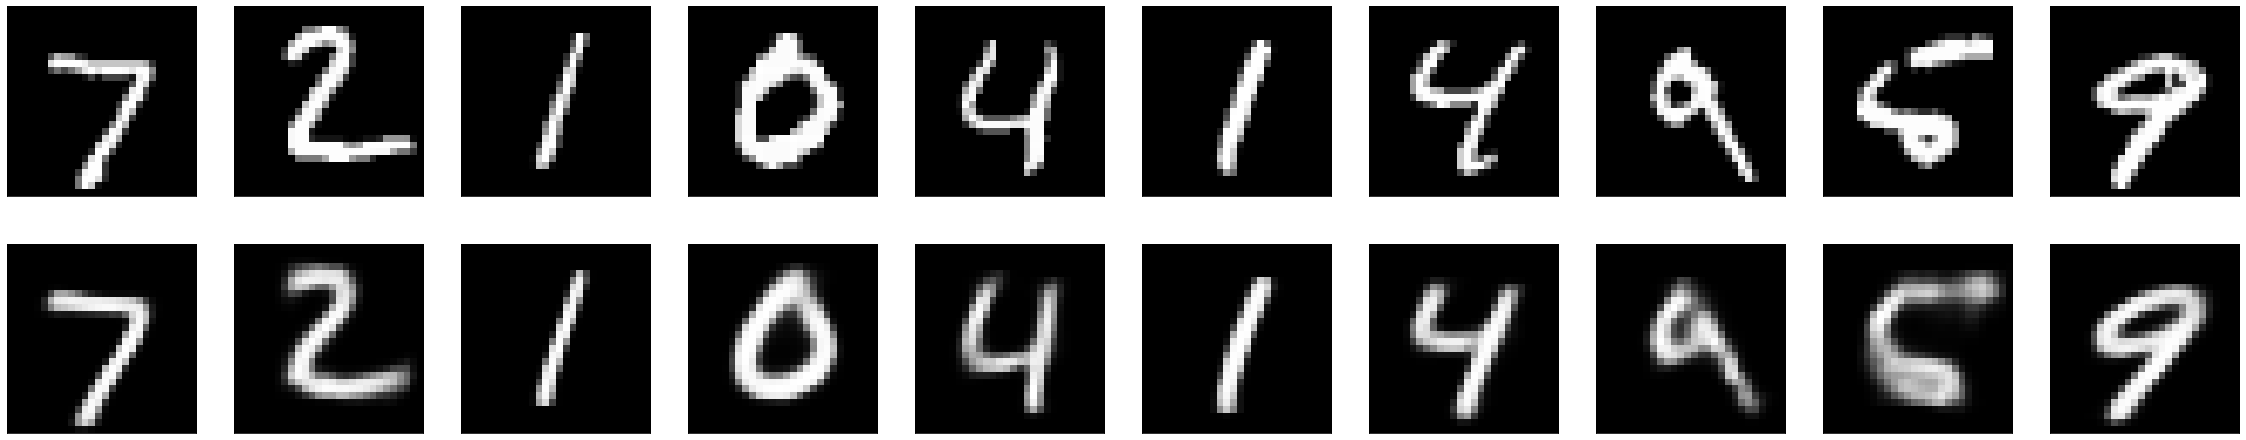

(10, 10)


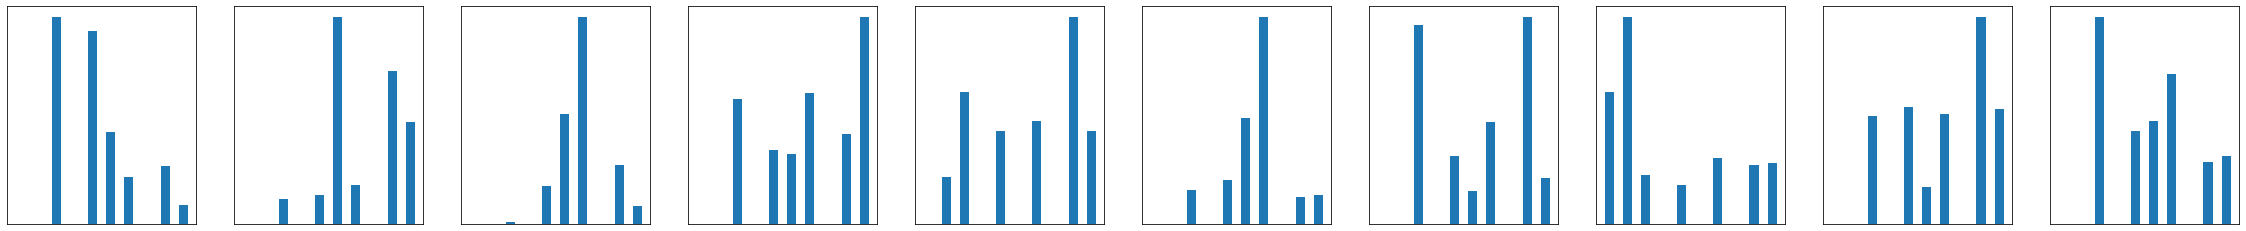

In [27]:
sparseconvmax_ae = SparseConvolutionMaxpoolAutoEncoder(train_dir='/train_saprse_conv_maxpool', test_dir='/test_sparse_conv_maxpool')

sparseconvmax_ae.train(30000,keep_prob=1)

code = sparseconvmax_ae.plot_test(10, draw_code=True)

### 畫出第一層filter

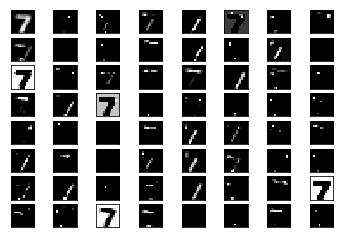

In [28]:
image1 = mnist.test.images[0]
sparseconvmax_ae.plot_conv_layer(sparseconvmax_ae.h_e[0], image1, 64)

### 畫出每個維度特徵圖

code shape: (10, 10)
layer shape: (?, 10)
image shape: (10, 28, 28, 1)


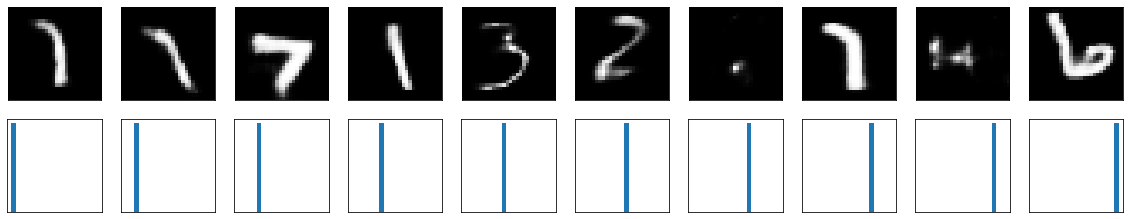

In [29]:
#temp = np.zeros(shape=(10,784))
code_test = np.zeros(shape=(10,10))

for i in range(len(code_test)):
    code_test[i,i] = 0.3
    
sparseconvmax_ae.plot_decode(code_test)

### 測試對抗noise能力

(?, 784)
(?, 28, 28, 1)


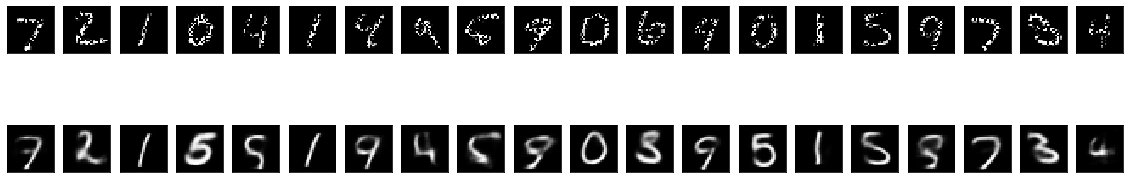

(20, 10)


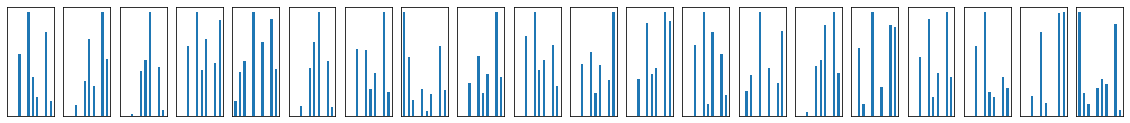

(?, 784)
(?, 28, 28, 1)


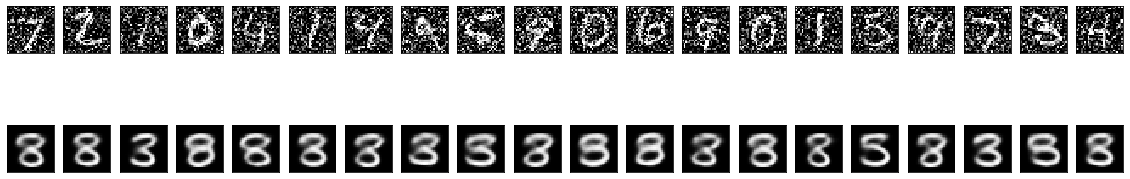

(20, 10)


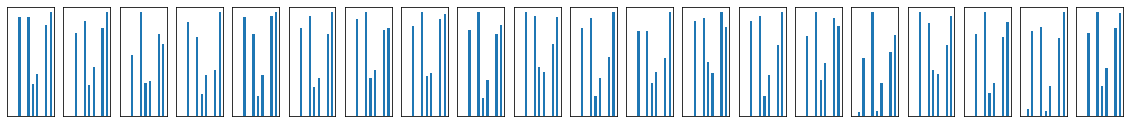

In [30]:
temp = sparseconvmax_ae.plot_test(test_size=20, test_data_gen=test_data_gen1)
temp = sparseconvmax_ae.plot_test(test_size=20, test_data_gen=test_data_gen2)

## Denoise Sparse Convolution AutoEncoder with max pooling

- [利用卷积自编码器对图片进行降噪 - 知乎](https://zhuanlan.zhihu.com/p/27902193)


- [numpy.random.randn — NumPy v1.15 Manual](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.randn.html)

In [31]:
class DenoiseSparseConvolutionMaxpoolAutoEncoder(SparseConvolutionMaxpoolAutoEncoder):
    def init_input_place(self):
        with tf.name_scope('input_data'):
            self.x_input = tf.placeholder(tf.float32, shape=[None, 784])
            self.x_input_reshape = tf.reshape(self.x_input, [-1, 28, 28, 1]) #28 X 28 X 1

            self.x_target = tf.placeholder(tf.float32, shape=[None, 784])
            self.x_target_reshape = tf.reshape(self.x_target, [-1, 28, 28, 1]) #28 X 28 X 1
        
        with tf.name_scope('control_variable'):
            self.keep_prob = tf.placeholder(tf.float32)
        
    def add_noise(self, imgs):
        # 加入噪声
        noise_factor = 0.5
        #print(*imgs.shape)
        # 產生平均為0，標準差為0.5 的噪聲
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        #noisy_imgs = imgs 
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        return noisy_imgs
    
    def train_data_gen(self,n=60, keep_prob=1):
        batch = mnist.train.next_batch(n)[0]
        noise_batch = self.add_noise(batch)
        feed_dict = {self.x_input:noise_batch, self.x_target:batch, self.keep_prob:keep_prob}
        return noise_batch, feed_dict
    
    def test_data_gen(self,obj=None,n=10,keep_prob=1):
        batch = mnist.test.images[0:n, :]
        noise_batch = self.add_noise(batch)
        feed_dict = {self.x_input:noise_batch, self.x_target:batch, self.keep_prob:keep_prob}
        return noise_batch, feed_dict
    

max_pool_2x2
(?, 28, 28, 64)
(?, 14, 14, 64)
max_pool_2x2
(?, 14, 14, 64)
(?, 7, 7, 64)
max_pool_2x2
(?, 7, 7, 32)
(?, 4, 4, 32)
max_pool_2x2
(?, 4, 4, 32)
(?, 2, 2, 32)
max_pool_2x2
(?, 2, 2, 10)
(?, 1, 1, 10)
max_unpool_2x2
(?, 1, 1, 32)
(?, ?, ?, 32)
max_unpool_2x2
(?, 2, 2, 32)
(?, ?, ?, 32)
max_unpool_2x2
(?, 4, 4, 64)
(?, ?, ?, 64)
max_unpool_2x2
(?, 7, 7, 64)
(?, ?, ?, 64)
max_unpool_2x2
(?, 14, 14, 64)
(?, ?, ?, 64)


/home/allenyl/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


step 0, loss 4.11262
step 100, loss 0.306156
step 200, loss 0.287998
step 300, loss 0.285903
step 400, loss 0.300266
step 500, loss 0.270494
step 600, loss 0.28709
step 700, loss 0.2565
step 800, loss 0.273433
step 900, loss 0.255038
step 1000, loss 0.25481
step 1100, loss 0.243025
step 1200, loss 0.234313
step 1300, loss 0.253355
step 1400, loss 0.229458
step 2000, loss 0.222733
step 3000, loss 0.212756
step 4000, loss 0.215865
step 5000, loss 0.22313
step 6000, loss 0.201454
step 7000, loss 0.20219
step 8000, loss 0.222179
step 9000, loss 0.203219
step 10000, loss 0.201326
step 11000, loss 0.208047
step 12000, loss 0.201315
step 13000, loss 0.189699
step 14000, loss 0.193834
step 15000, loss 0.193895
step 16000, loss 0.186526
step 17000, loss 0.173373
step 18000, loss 0.191207
step 19000, loss 0.184971
step 20000, loss 0.188807
step 21000, loss 0.183482
step 22000, loss 0.187172
step 23000, loss 0.182751
step 24000, loss 0.190808
step 25000, loss 0.178835
step 26000, loss 0.189902
st

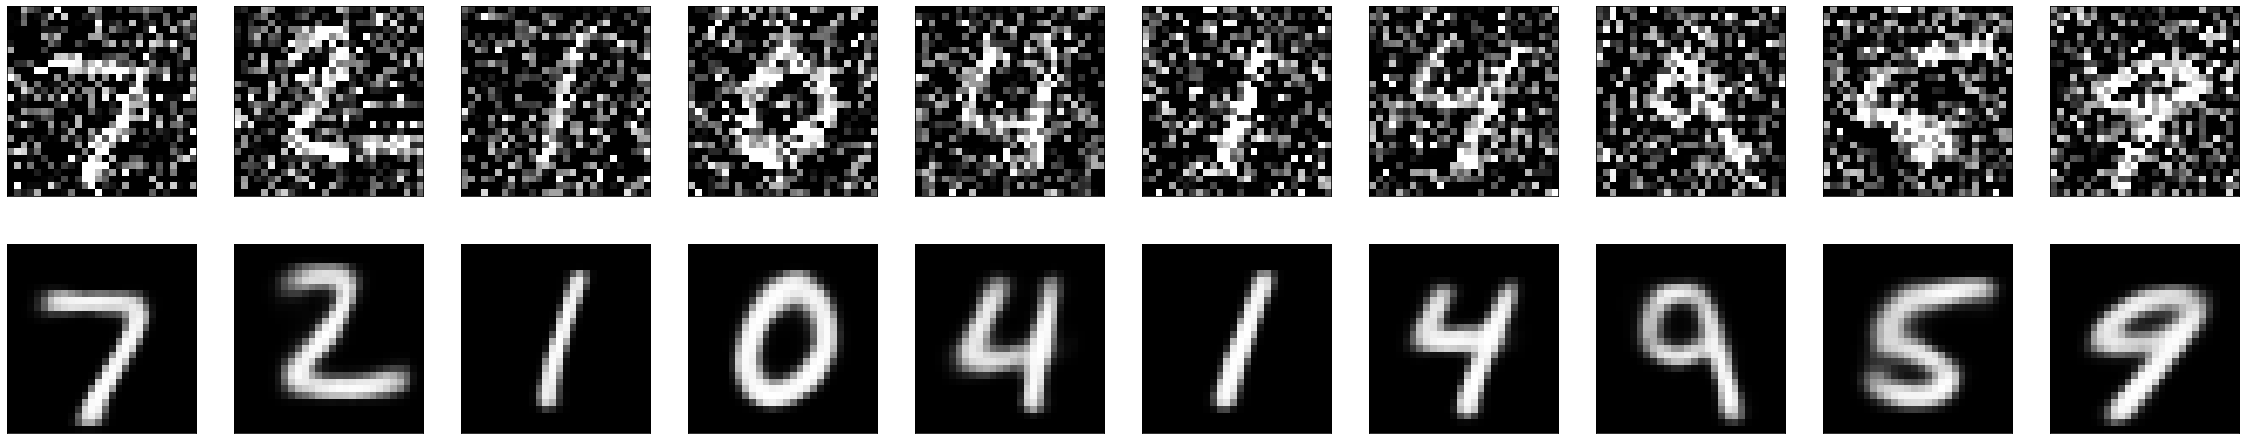

(10, 10)


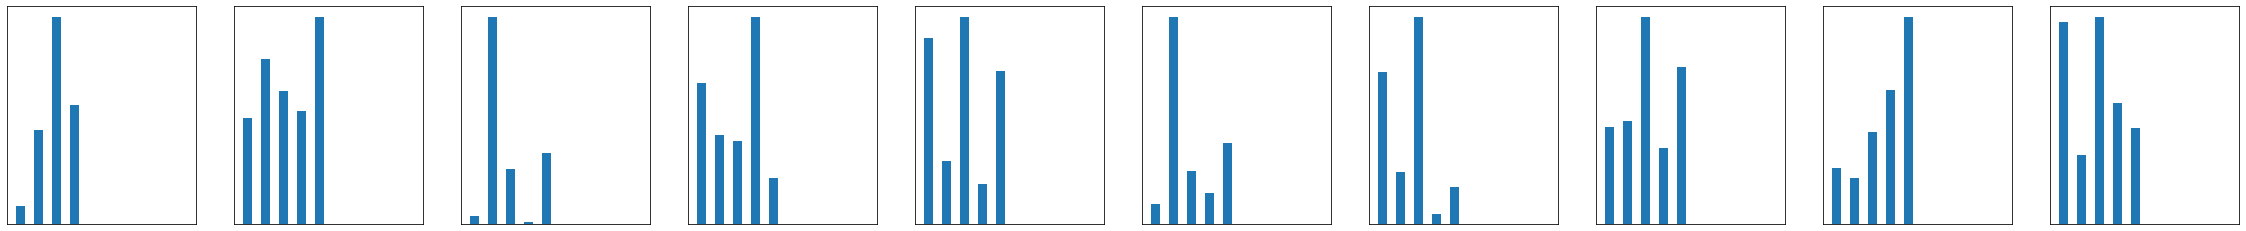

In [32]:
denoisesparseconvmax_ae = DenoiseSparseConvolutionMaxpoolAutoEncoder(train_dir='/train_denoise_saprse_conv_maxpool', test_dir='/test_denoise_sparse_conv_maxpool')

denoisesparseconvmax_ae.train(30000)

code = denoisesparseconvmax_ae.plot_test(10, draw_code=True)

code shape: (10, 10)
layer shape: (?, 10)
image shape: (10, 28, 28, 1)


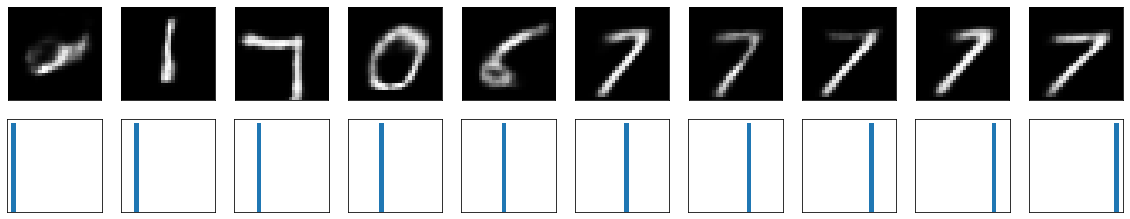

In [33]:
#temp = np.zeros(shape=(10,784))
code_test = np.zeros(shape=(10,10))

for i in range(len(code_test)):
    code_test[i,i] = 0.3
    
denoisesparseconvmax_ae.plot_decode(code_test)

### 測試對抗noise能力

(?, 784)
(?, 28, 28, 1)


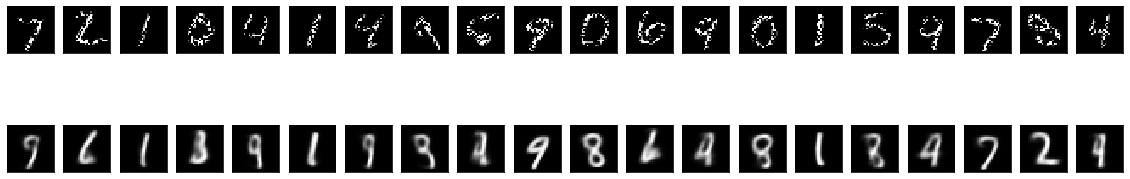

(20, 10)


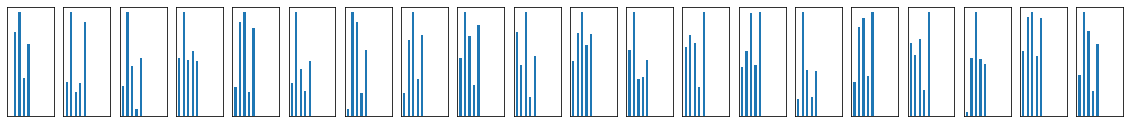

(?, 784)
(?, 28, 28, 1)


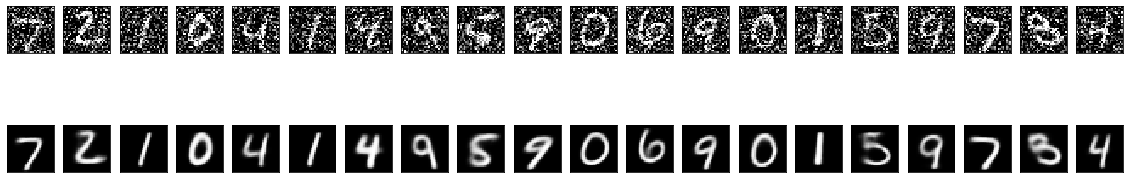

(20, 10)


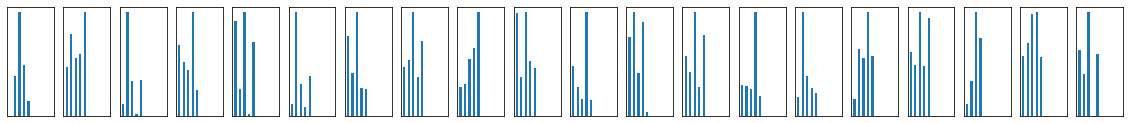

In [34]:
temp = denoisesparseconvmax_ae.plot_test(test_size=20, test_data_gen=test_data_gen1)
temp = denoisesparseconvmax_ae.plot_test(test_size=20, test_data_gen=test_data_gen2)

# Contractive Autoencoder(CAE)

- [Neural networks [6.7] : Autoencoder - contractive autoencoder - YouTube](https://youtu.be/79sYlJ8Cvlc)

- [Hugo Larochelle](http://info.usherbrooke.ca/hlarochelle/neural_networks/content.html)



In [41]:
class ContractiveConvolutionMaxpoolAutoEncoder(SparseConvolutionMaxpoolAutoEncoder):
    def loss_func(self):
        with tf.name_scope('cost'):
            
            # reconstruction term
            self.x_reconstruct = self.h_d[-1]
            
            
#             # 計算KL divergence 時，必須要通過 sigmoid，因為KL divergence 是計算機率，其中有log(1-P)項，
#             # 如果沒有通過sigmoid，算出來P可能大於1，就會變成nan
#             from functools import reduce
#             beta = 7.5e-3
#             kl_div_loss = reduce(lambda x, y: x+y, 
#                                  map(lambda x: tf.reduce_sum(kl_div(0.02, tf.reduce_mean(x,0))), 
#                                      [tf.nn.sigmoid(tf.layers.Flatten()(self.h_e[-1]))]))
            
            # 計算 Jacobian loss
            from tensorflow.python.ops.parallel_for.gradients import jacobian, batch_jacobian
            alpha = 1e-1
            print(self.h_e[-1].shape)
            print(self.x_input.shape)
            # calculate jacobian
            J=batch_jacobian(self.h_e[-1],self.x_input)
            print(J.shape)
            # square of Frobenius norm of jacobian
            jacobian_loss = tf.pow(tf.norm(J, ord='fro', axis=[-2,-1]),2)
            
            # 使用平方差loss 的話，輸出層不能加激發函數，而且decode layers 的激發函數必須用sigmoid
            # 用sigmoid就無法建立很深層的layers
            #loss = tf.pow((x_reconstruct - x_origin),2)

            # 使用cross entropy 的效果比平方差效果更好，而且隱藏層的激發函數都可以使用relu
            # relu 的好處是可以建立很深的layers
            logits_ = self.h_d[-2]
            targets_ = self.x_target_reshape
            
            # 思考問題：為何要用 sigmoid_cross_entropy_with_logits？
            # ans: 因為每個 pixel 的值介於0~1，可以當成機率值，計算cross entropy，又sigmoid 是element-wise計算cross entropy
            #      而softmax 是強迫所有輸出值和為1，顯然在圖片上，我們不需要所有輸出和為1。
            #loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits_) + beta * kl_div_loss
            loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits_) + alpha * jacobian_loss
            #loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=targets_, logits=logits_) + beta * kl_div_loss
            self.cost = tf.reduce_mean(loss)

        with tf.name_scope('train_step'):
            self.optimizer = tf.train.AdamOptimizer(0.001).minimize(self.cost)    




max_pool_2x2
(?, 28, 28, 64)
(?, 14, 14, 64)
max_pool_2x2
(?, 14, 14, 64)
(?, 7, 7, 64)
max_pool_2x2
(?, 7, 7, 32)
(?, 4, 4, 32)
max_pool_2x2
(?, 4, 4, 32)
(?, 2, 2, 32)
max_pool_2x2
(?, 2, 2, 10)
(?, 1, 1, 10)
max_unpool_2x2
(?, 1, 1, 32)
(?, ?, ?, 32)
max_unpool_2x2
(?, 2, 2, 32)
(?, ?, ?, 32)
max_unpool_2x2
(?, 4, 4, 64)
(?, ?, ?, 64)
max_unpool_2x2
(?, 7, 7, 64)
(?, ?, ?, 64)
max_unpool_2x2
(?, 14, 14, 64)
(?, ?, ?, 64)
(?, 10)
(?, 784)
(?, 10, 784)


/home/allenyl/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


step 0, loss 1.32155
step 100, loss 0.243373
step 200, loss 0.212815
step 300, loss 0.173799
step 400, loss 0.171381
step 500, loss 0.160798
step 600, loss 0.160607
step 700, loss 0.154915
step 800, loss 0.160467
step 900, loss 0.158405
step 1000, loss 0.143278
step 1100, loss 0.141029
step 1200, loss 0.146671
step 1300, loss 0.141613
step 1400, loss 0.13387
step 2000, loss 0.125062
step 3000, loss 0.130784
step 4000, loss 0.114645
step 5000, loss 0.10734
step 6000, loss 0.119462
step 7000, loss 0.111149
step 8000, loss 0.106291
step 9000, loss 0.105353
step 10000, loss 0.103247
step 11000, loss 0.113795
step 12000, loss 0.110172
step 13000, loss 0.103503
step 14000, loss 0.102237
step 15000, loss 0.098579
step 16000, loss 0.105451
step 17000, loss 0.111347
step 18000, loss 0.104803
step 19000, loss 0.0947132
step 20000, loss 0.0963958
step 21000, loss 0.101646
step 22000, loss 0.0984568
step 23000, loss 0.10568
step 24000, loss 0.10136
step 25000, loss 0.1017
step 26000, loss 0.098523

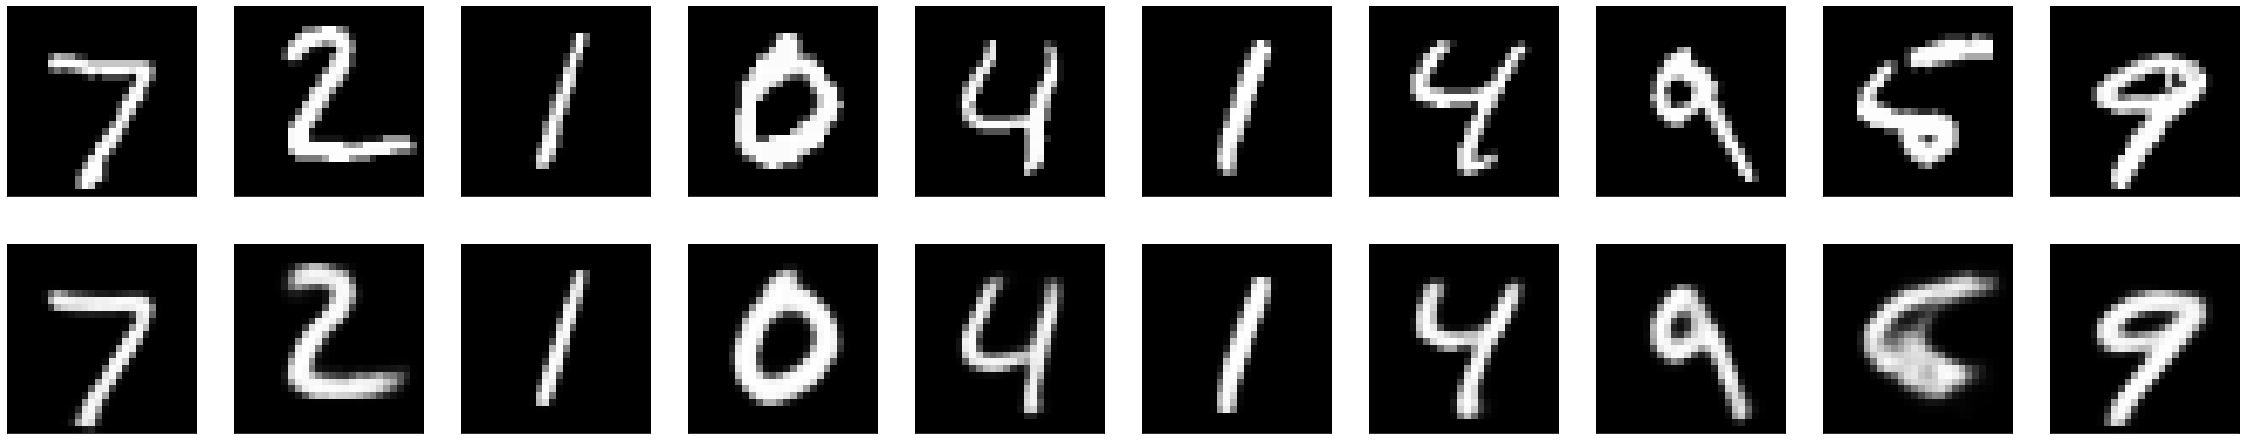

(10, 10)


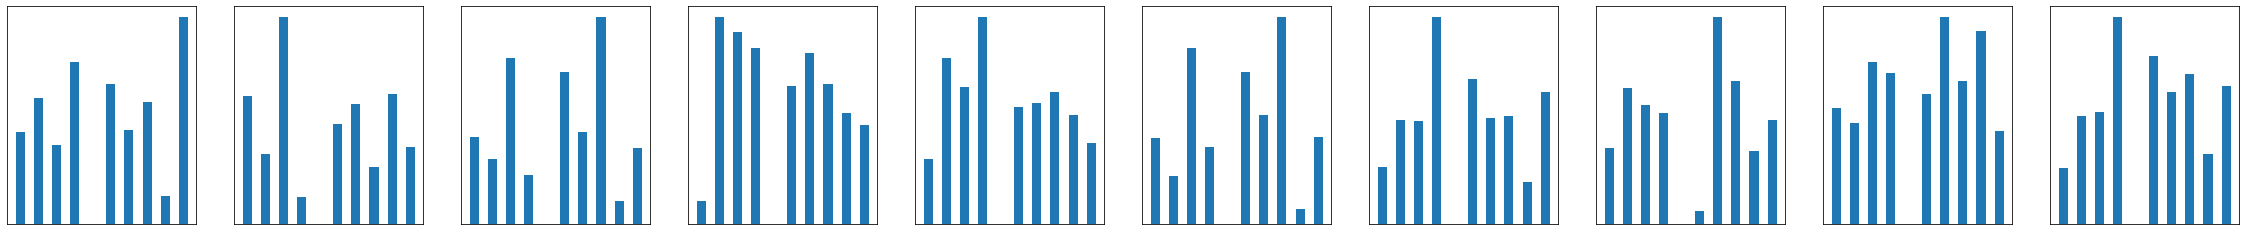

In [42]:
cae = ContractiveConvolutionMaxpoolAutoEncoder(test_size=100, train_dir='/train_CAE', test_dir='/test_CAE')

cae.train(30000)

code = cae.plot_test(10, draw_code=True)


code shape: (10, 10)
layer shape: (?, 10)
image shape: (10, 28, 28, 1)


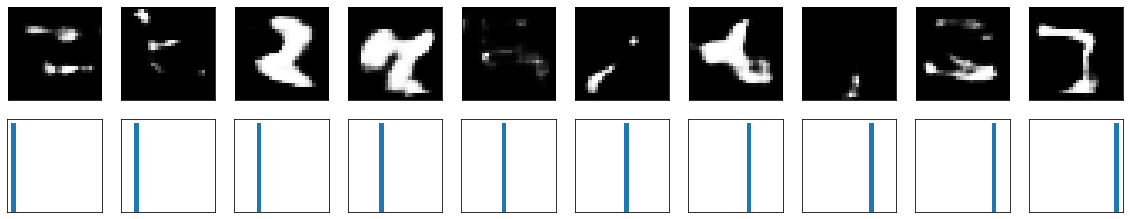

In [46]:
#temp = np.zeros(shape=(10,784))
import numpy as np
code_test = np.zeros(shape=(10,10))

for i in range(len(code_test)):
    code_test[i,i] = 1
    
cae.plot_decode(code_test)

### 測試對抗noise能力

(?, 784)
(?, 28, 28, 1)


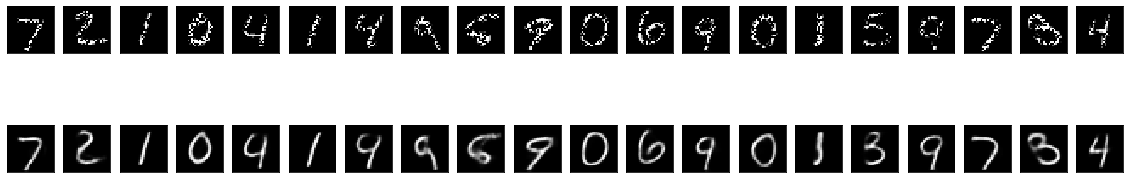

(20, 10)


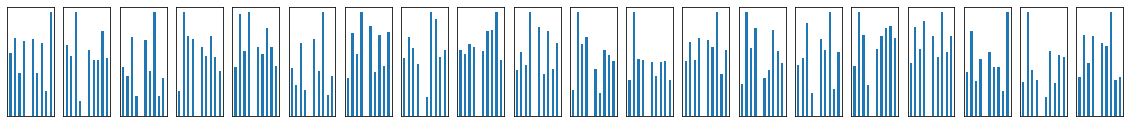

(?, 784)
(?, 28, 28, 1)


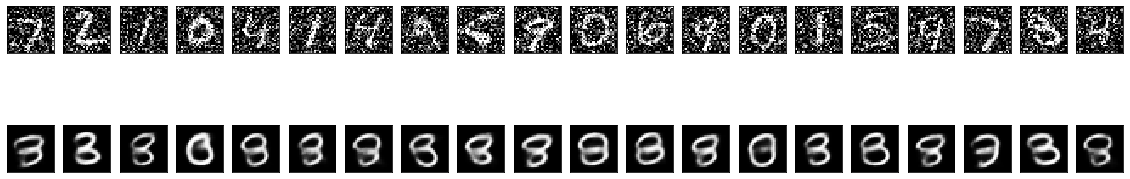

(20, 10)


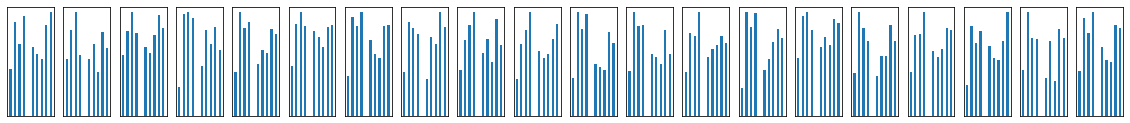

In [45]:
temp = cae.plot_test(test_size=20, test_data_gen=test_data_gen1)
temp = cae.plot_test(test_size=20, test_data_gen=test_data_gen2)